In [6]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
from scipy.signal import argrelextrema
from sklearn.externals import joblib
from sklearn.tree import export_graphviz
from subprocess import call

train score :  0.8575967473253028
test score :  0.02913797537072482
FCHI CAC Return vs Market
model 1.4985002224363622 market 1.2005005471335108 action 12


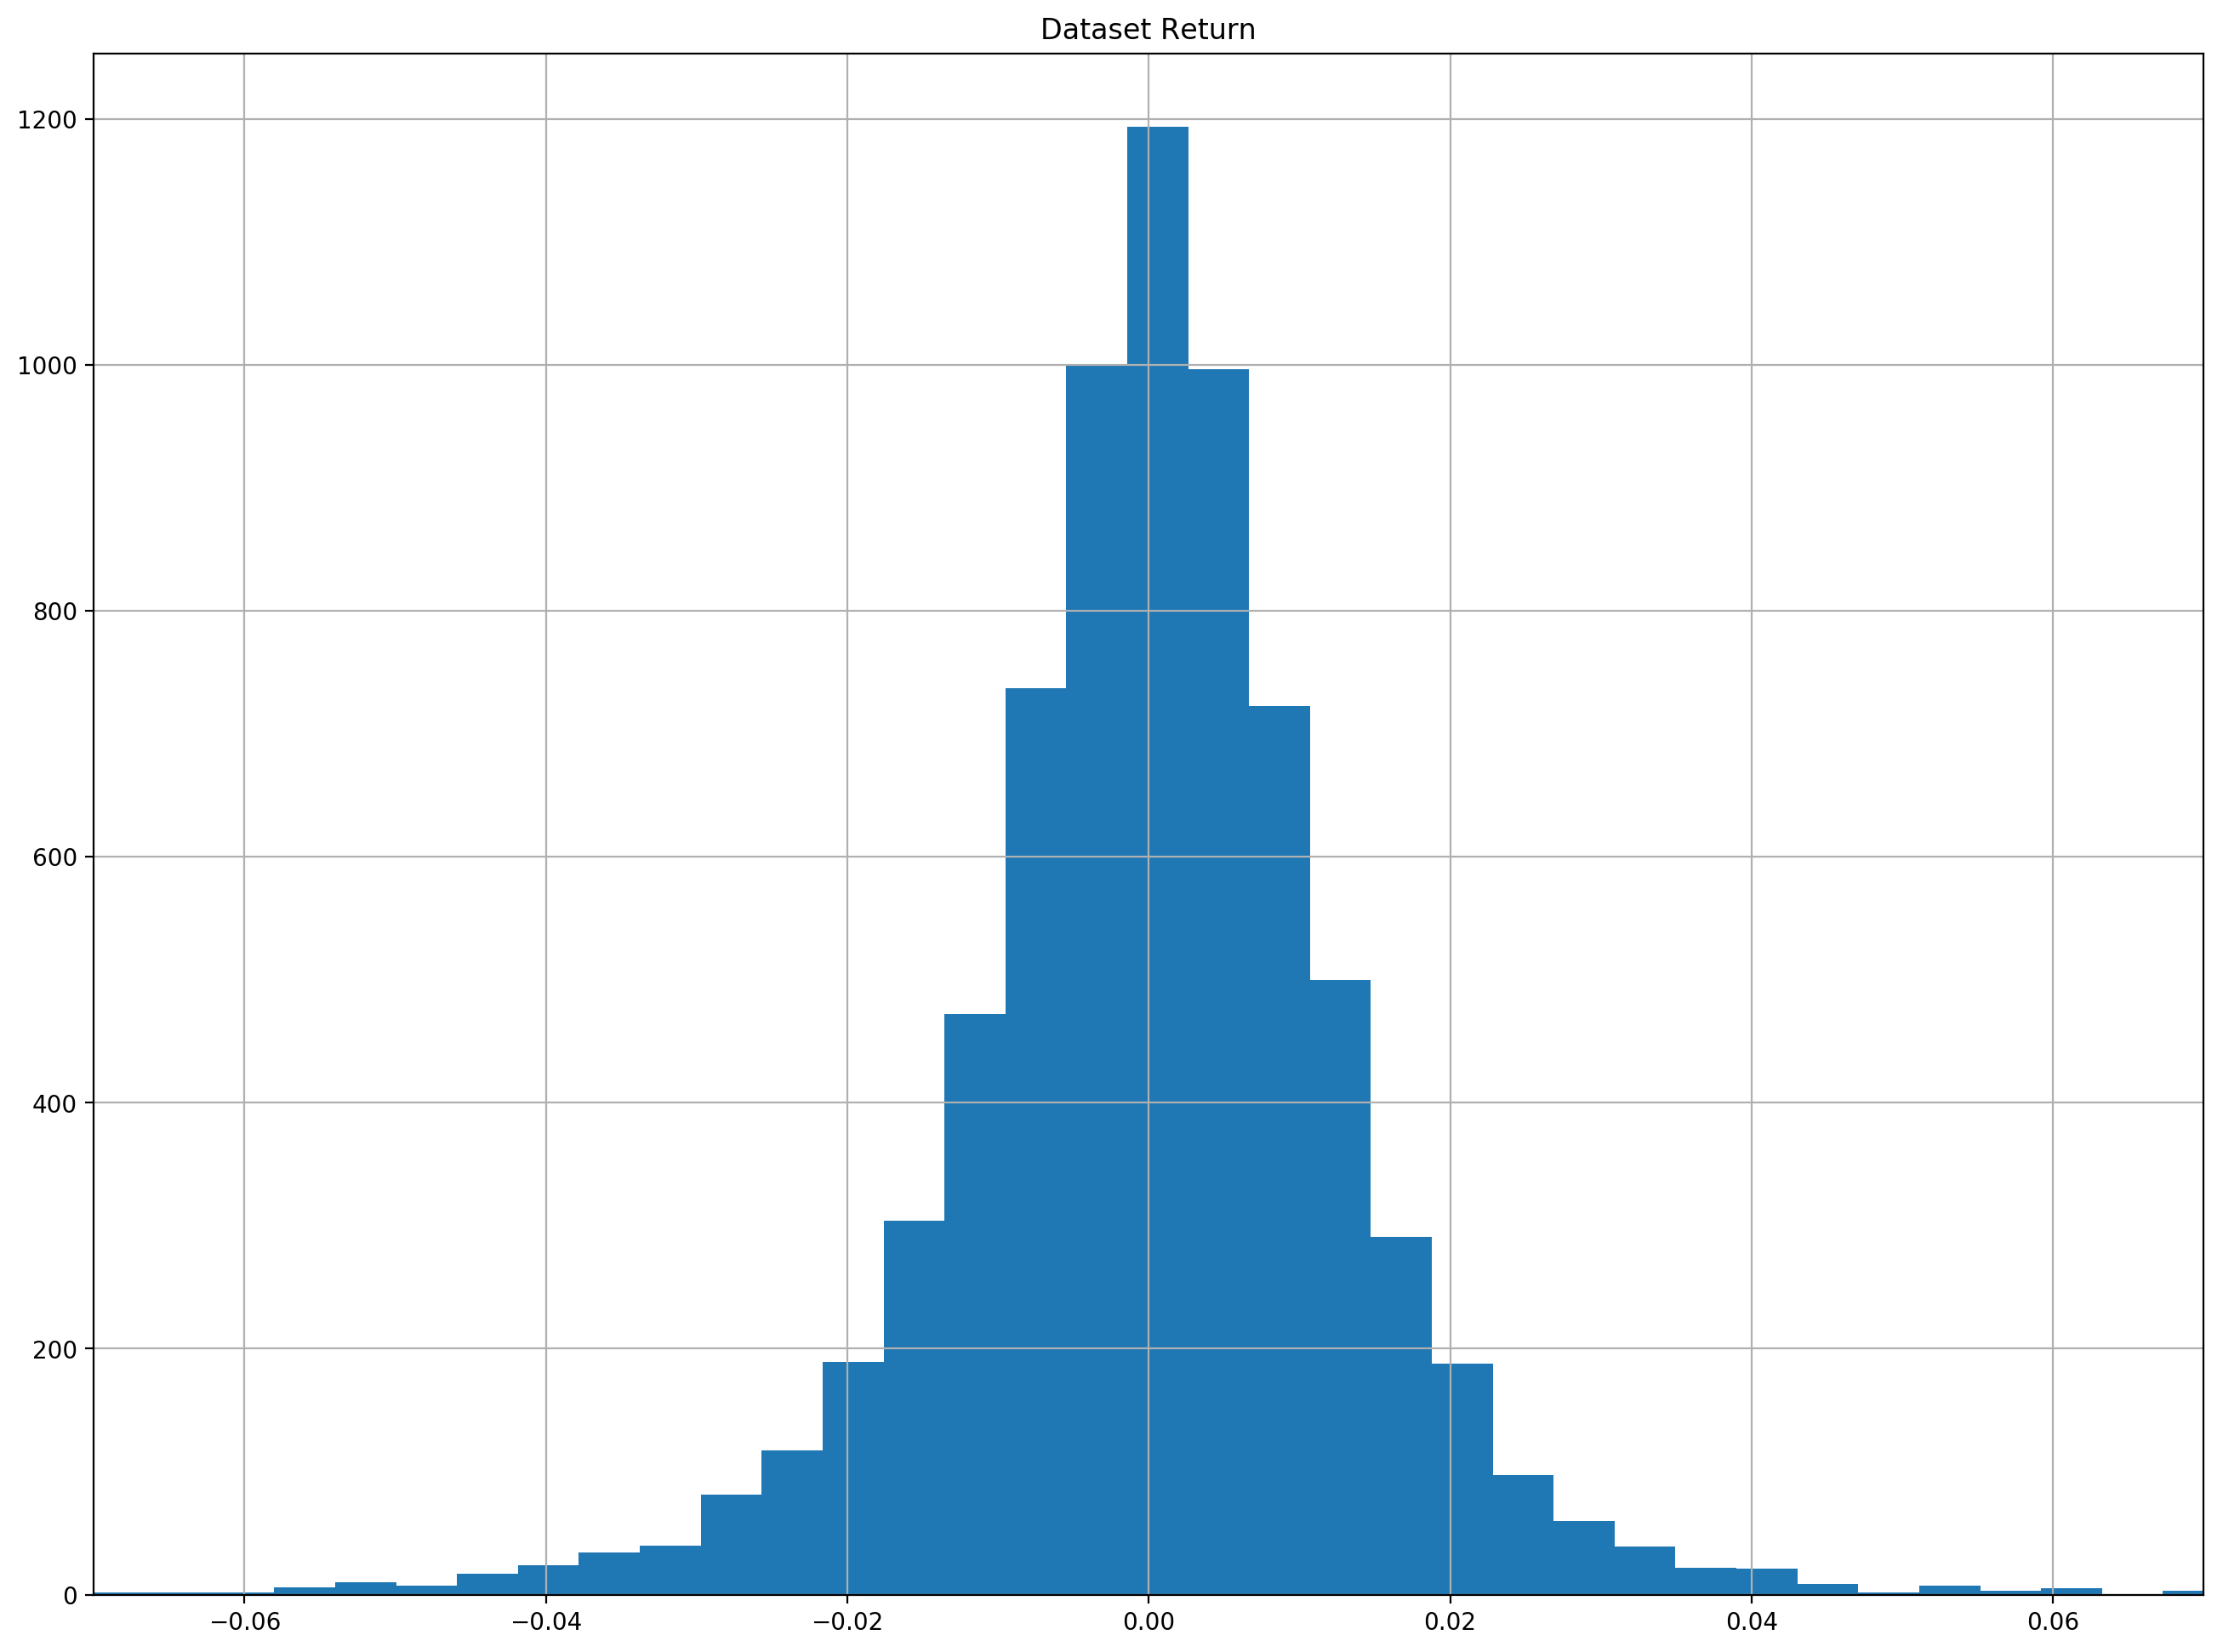

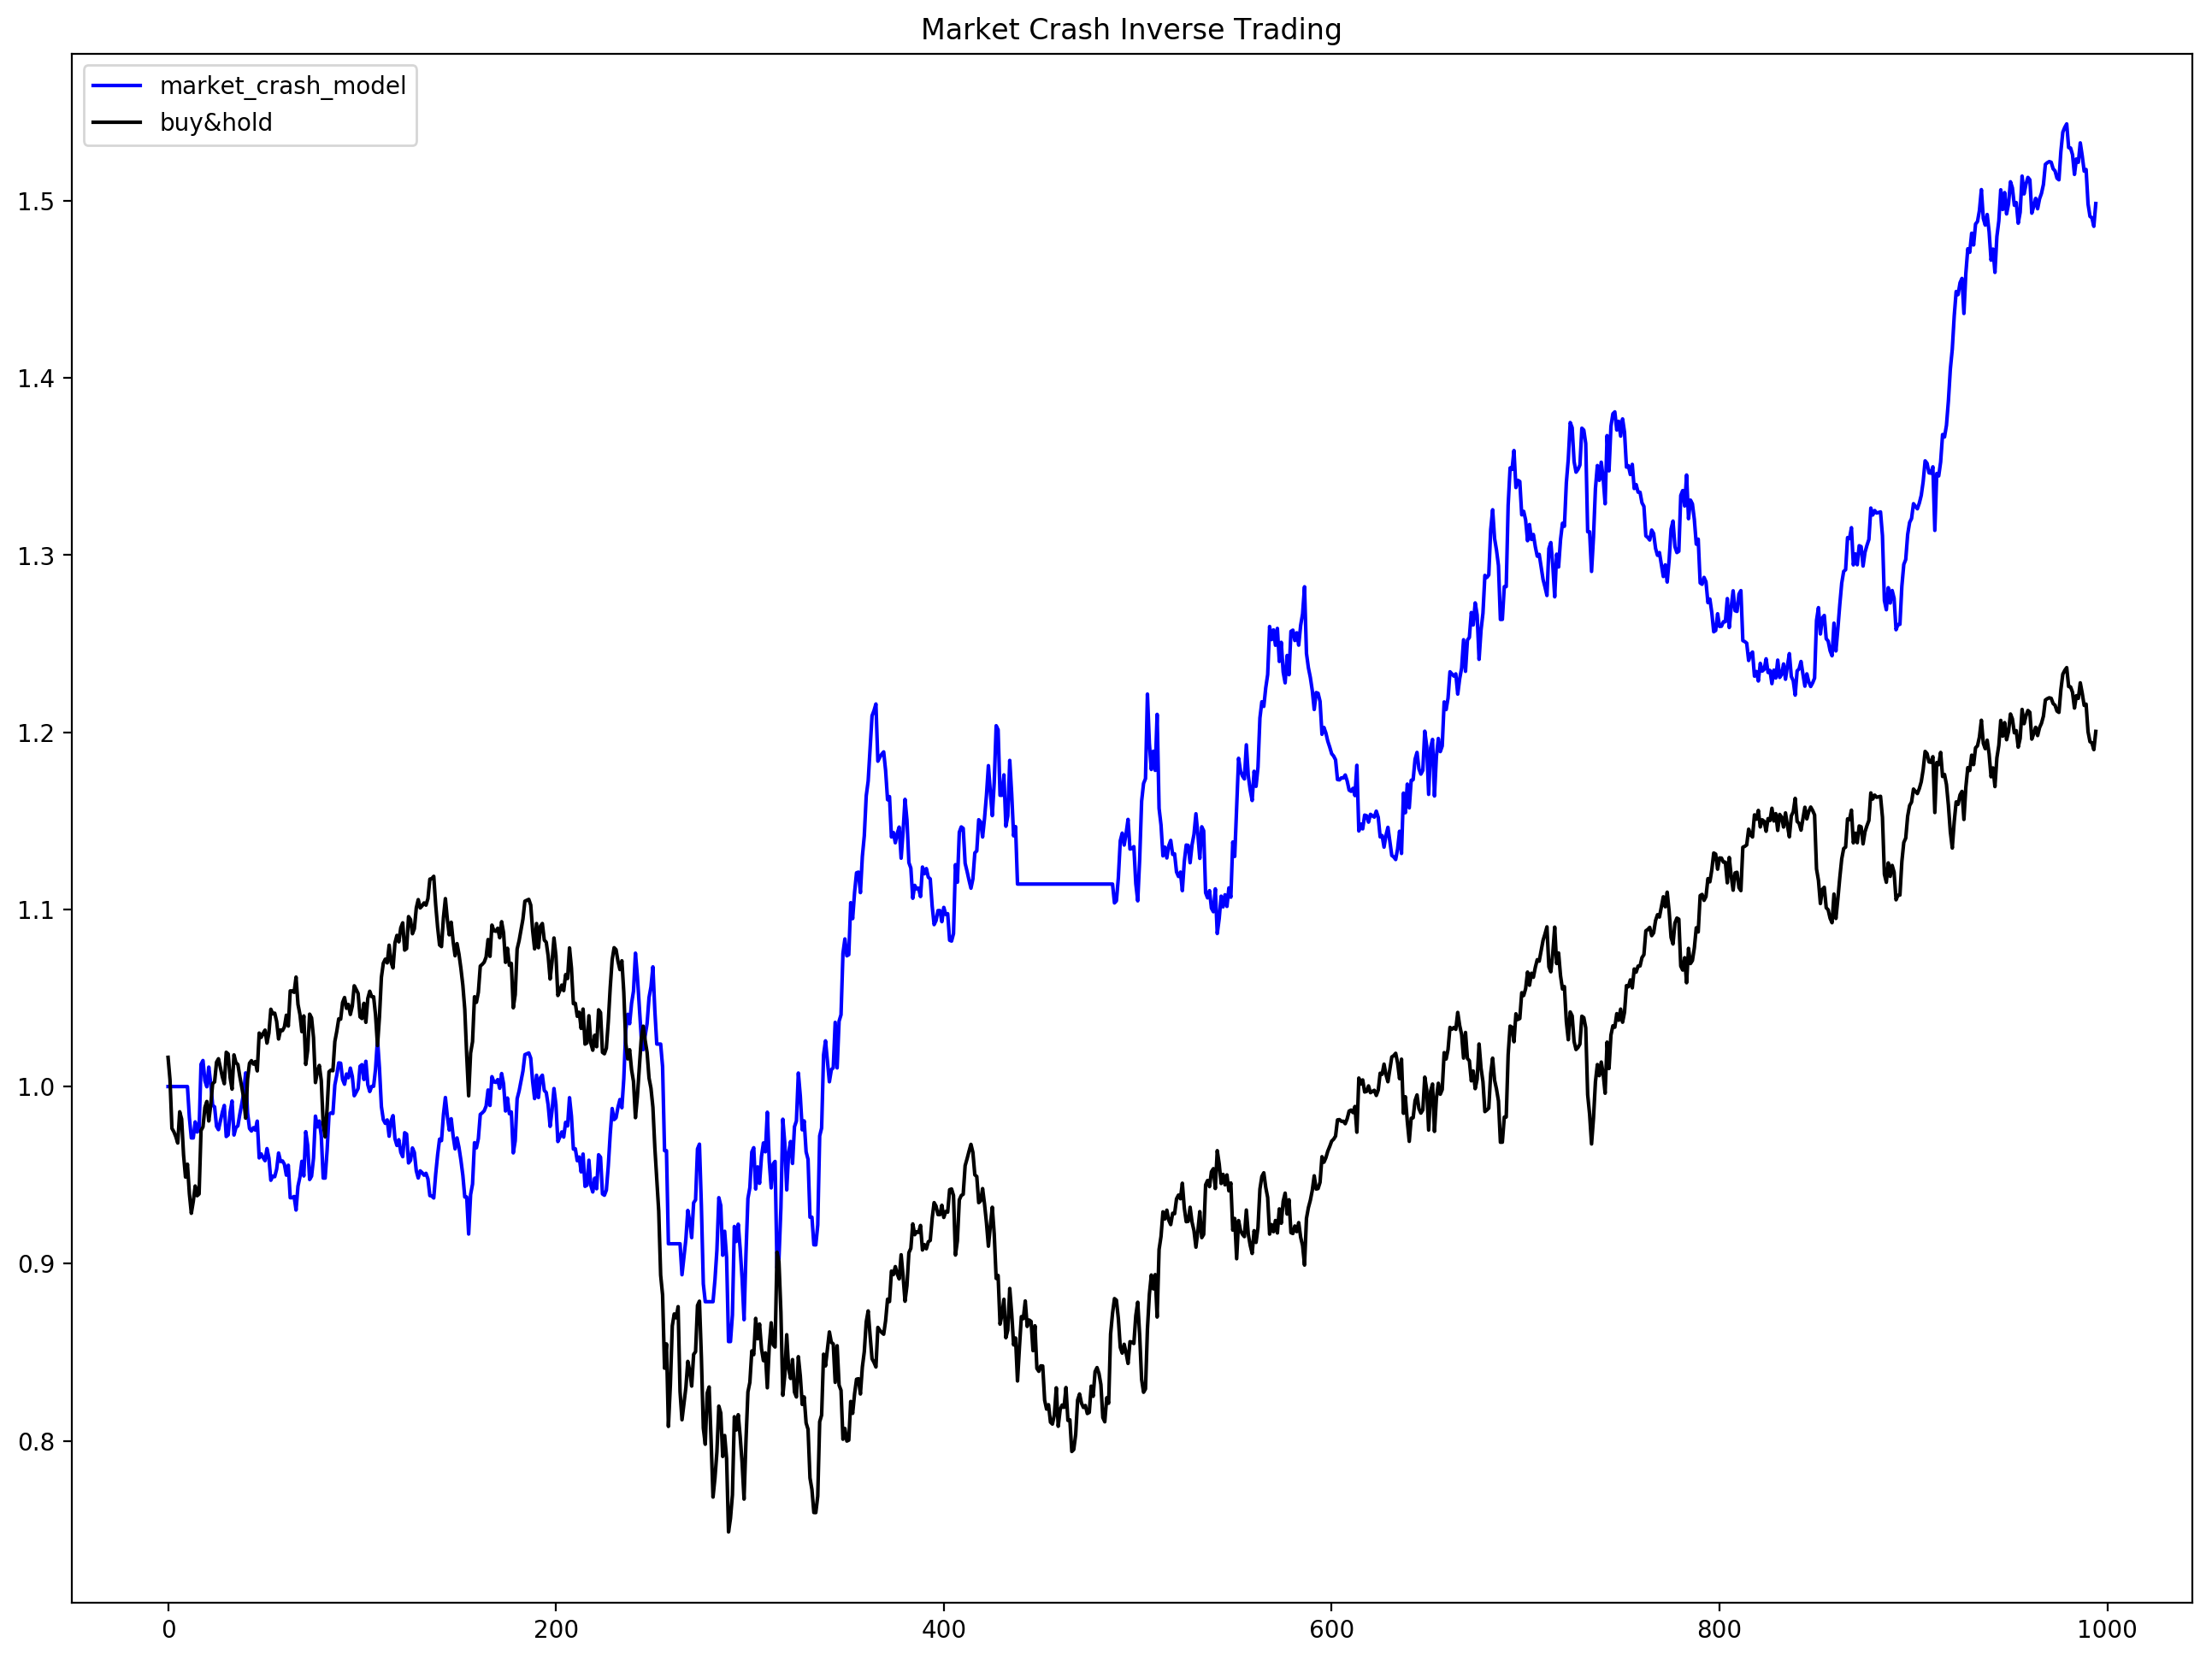

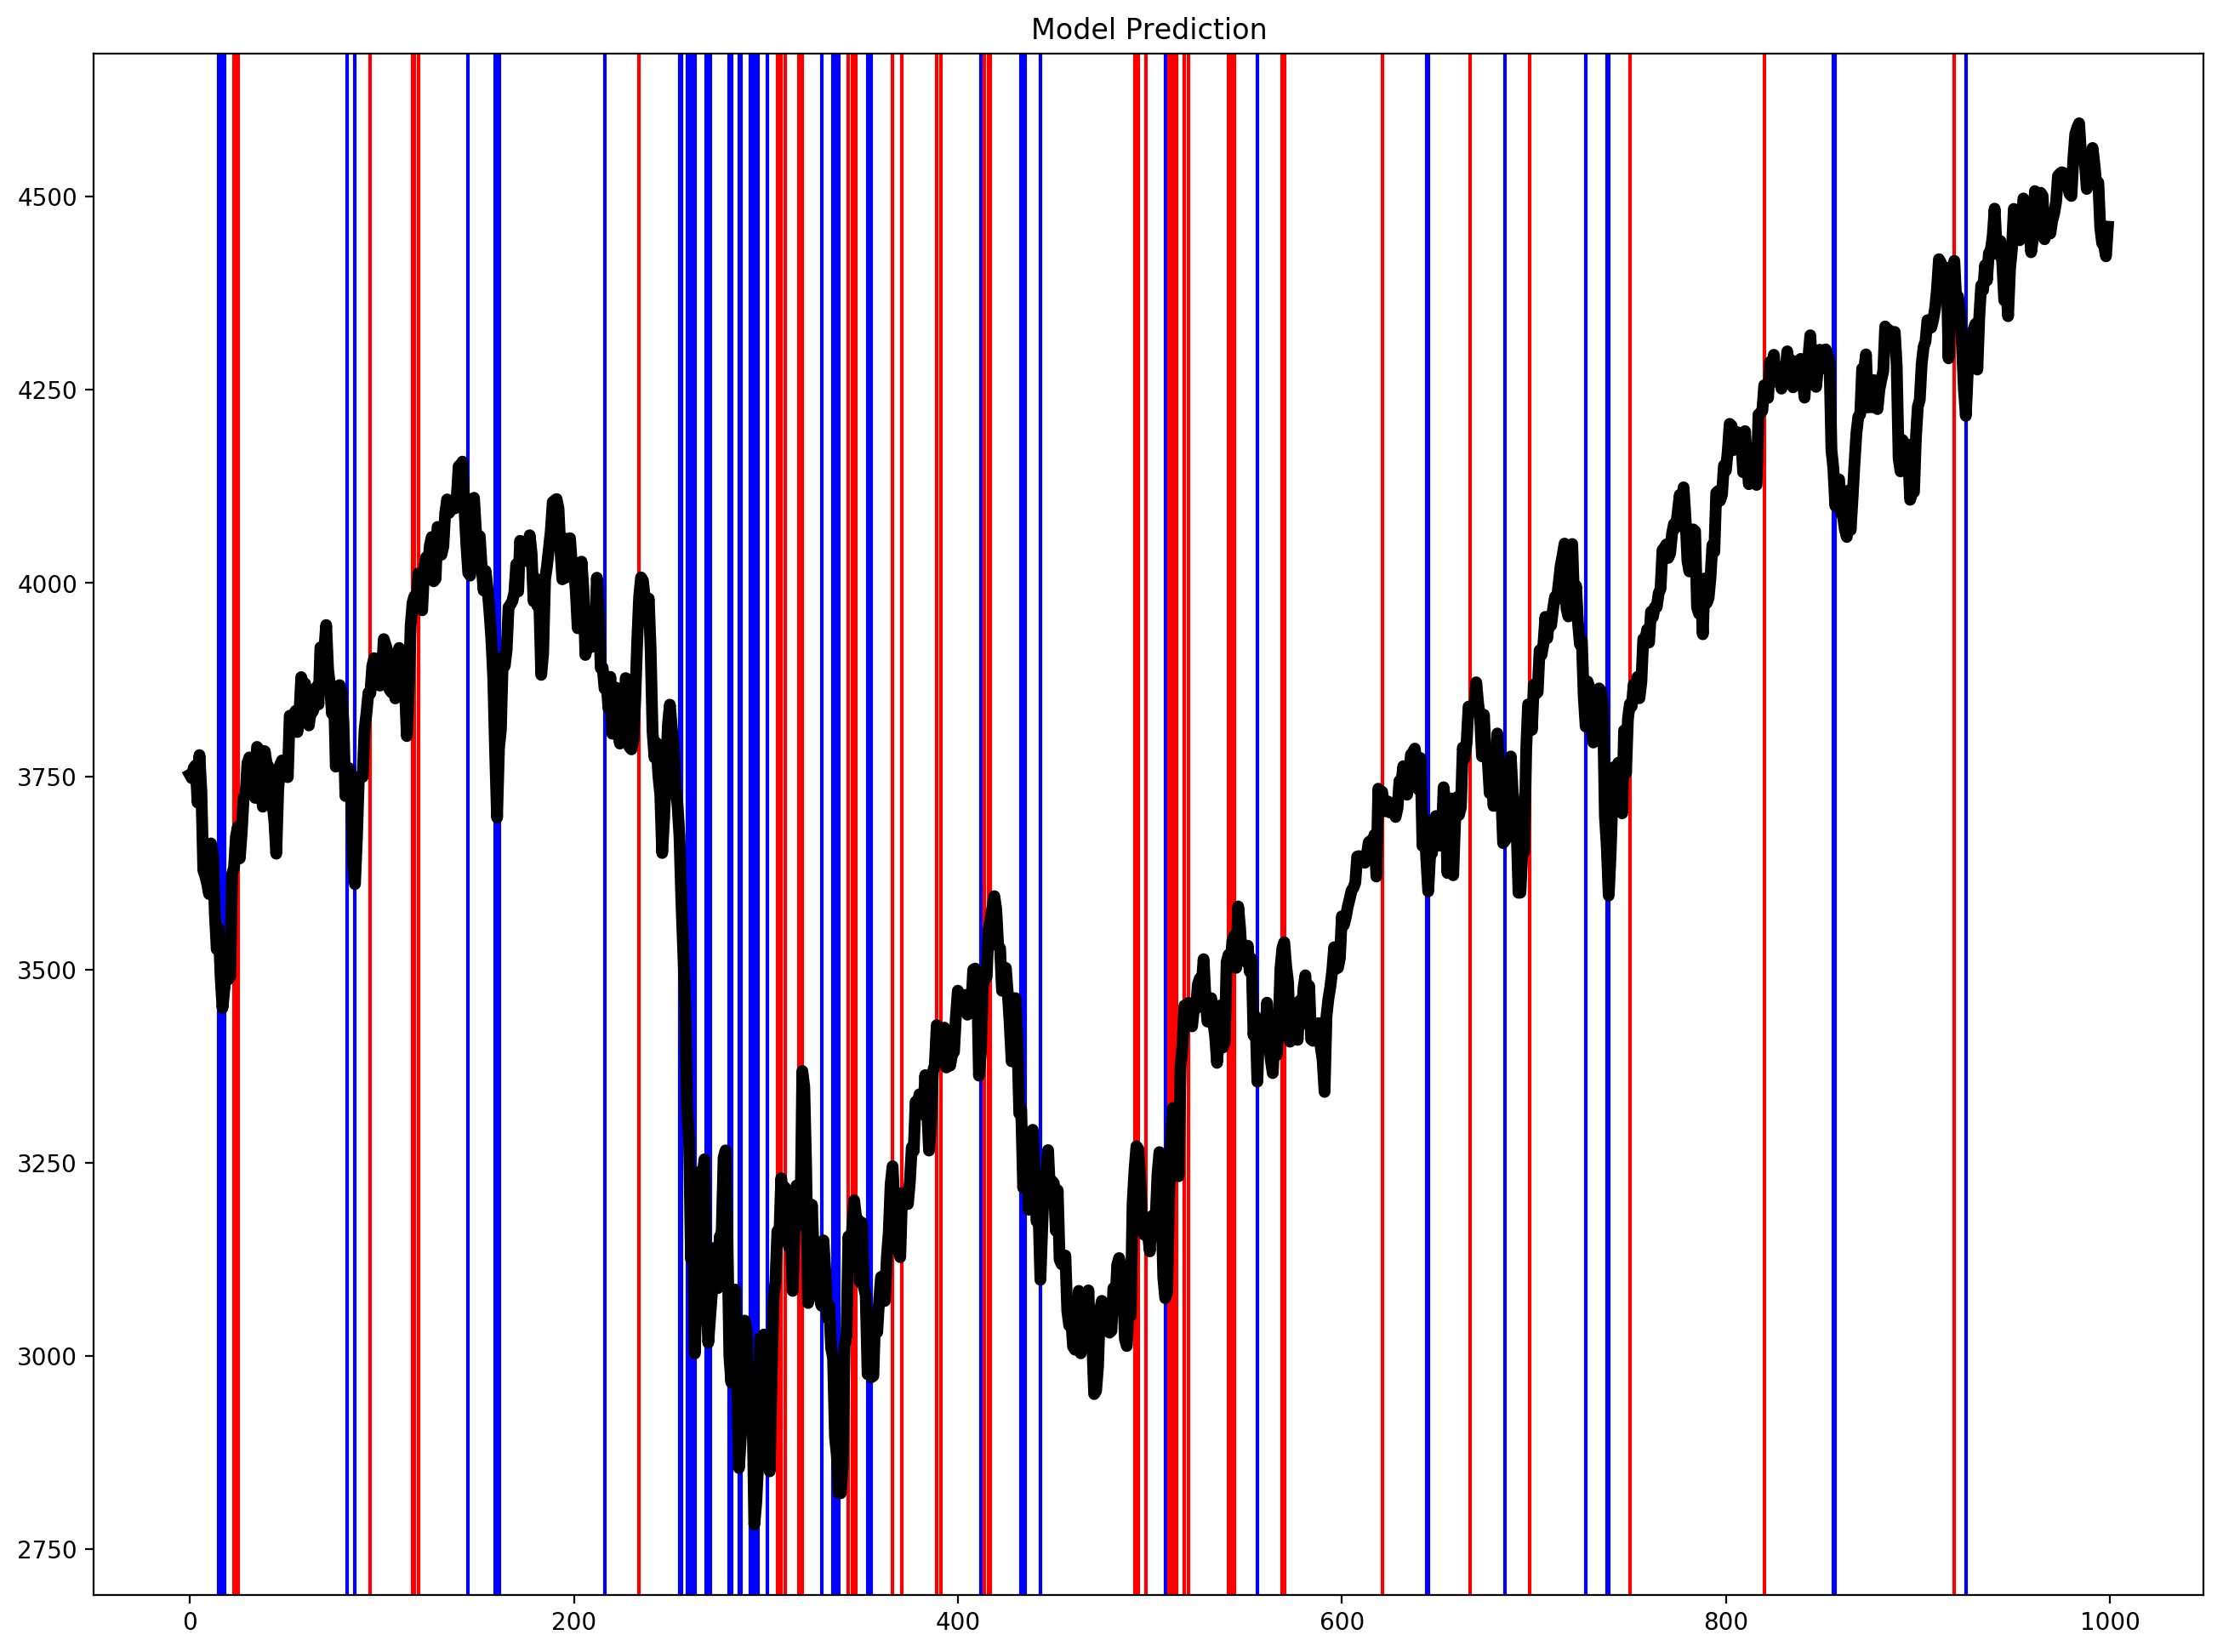

In [7]:
data = pd.read_csv("MarketData/FCHI_CAC_Daily.csv") 
data = data.dropna()

max_slope = 1 + 60
max_vol = 1 + 60
for i in range(1, max_slope):
    data['r'+str(i)] = data.Close.pct_change(i)
for i in range(5, max_vol):
    data['vol'+str(i)] = data.Close.rolling(i).std()
    
data['Return'] = data.Close.pct_change()
data = data.dropna().iloc[100:,:].reset_index().iloc[:,1:]

n= 20 # number of points to be checked before and after 
# Find local peaks
reg_target = pd.DataFrame()
reg_target['Date'] = data.Date
reg_target['Close'] = data.Close
reg_target['min'] = data.iloc[argrelextrema(data.Close.values, np.less_equal, order=n)[0]]['Close']
reg_target['max'] = data.iloc[argrelextrema(data.Close.values, np.greater_equal, order=n)[0]]['Close']

reg_target['is_min'] = (reg_target['min'] > 0).astype(int) * -1 
reg_target['is_max'] = (reg_target['max'] > 0).astype(int) * 1 
reg_target['target'] = reg_target.is_min + reg_target.is_max

reg_target = reg_target.dropna(axis=1)

train_start = 0
train_end = train_start+5000
test_point = 1000
X_train = data.iloc[train_start:train_end, 7:-1]
# X_train = data.iloc[train_start:train_end, 8:]

y_train = reg_target['target'].iloc[train_start:train_end].values
X_test = data.iloc[train_end:train_end+test_point, 7:-1]

# X_test = data.iloc[train_end:train_end+test_point, 8:]
y_test = reg_target['target'].iloc[train_end:train_end+test_point].values

price_train = data.Close.iloc[train_start:train_end].values
price_test = data.Close.iloc[train_end:train_end+test_point].values


regr2 = joblib.load('Weight/random_forest_CAC.pkl')

print('train score : ', regr2.score(X_train, y_train))
print('test score : ', regr2.score(X_test, y_test))

pred_train = regr2.predict(X_train)
pred_test = regr2.predict(X_test)*n
    
action = 0 
ret = 1
bh = 1 
log_ret = [] 
log_bh = [] 
action_vol = 5 
vol_buy = 40
vol_sell = 40
rule_buy = -1
rule_sell =  0.75

cost = 1 
move_trailing = 1.1 
stop_loss = 0.975

fchi_count_action = 0 
for i in range(action_vol, len(price_test)):
    change = (price_test[i] - price_test[i-1])/price_test[i-1]
    vol = price_test[i-action_vol:i].std()
    ret = ret * (1+change*action)
    bh = bh * (1+change)
    if pred_test[i] >= rule_sell and vol >= vol_sell: 
        action = -1
        cost = 0 
    elif pred_test[i] <= rule_buy  and vol >= vol_buy:
        if action == 0 :
            cost = ret
            fchi_count_action += 1 
        action = 1
        
    if action == 1 and ret >= cost * move_trailing:
        cost = ret  
    if ret <= cost * stop_loss :
        action = 0 
        cost = 0  
    log_ret.append(ret)
    log_bh.append(bh)

print('FCHI CAC Return vs Market')
print('model', ret, 'market', bh, 'action', fchi_count_action)

plt.figure(figsize=(16,12), dpi=200)
plt.title('Dataset Return')
data.r1.hist(bins=50)
plt.xlim(-0.07,0.07)
plt.show()


plt.figure(figsize=(16,12), dpi=200)
plt.title('Market Crash Inverse Trading')
plt.plot(log_ret, label='market_crash_model', color='blue')
plt.plot(log_bh, label='buy&hold', color='black')
plt.legend()
plt.savefig('Image/fchi_ret.png')
plt.show()

plt.figure(figsize=(16,12), dpi=200)
plt.title("Model Prediction")
for i in range(action_vol, len(price_test)):
    vol = price_test[i-action_vol:i].std()
    if pred_test[i] >= rule_sell and vol >= vol_sell: 
        plt.axvline(i, color='red')
    elif pred_test[i] <= rule_buy  and vol >= vol_buy:
        plt.axvline(i, color='blue') 
plt.plot(price_test, color='black', linewidth=5)
plt.savefig('Image/fchi_action.png')
plt.show()

# estimator = regr2.estimators_[5]

# export_graphviz(estimator, out_file='Image/fchi_tree.dot', feature_names = data.iloc[:,7:-1].columns,
#                 rounded = True, proportion = False, filled = True)
# call(['dot', '-Tpng', 'Image/fchi_tree.dot', '-o', 'Image/fchi_tree.png', '-Gdpi=150'])
# plt.figure(figsize = (32,18))
# plt.imshow(plt.imread('Image/fchi_tree.png'))
# plt.axis('off');
# plt.show();

ret_FCHI = ret 
mk_FCHI = bh

train score :  0.8664932444755491
test score :  0.09495950866894977
Nikkei Return vs Market
model 1.8483708455239565 market 1.3022231300497968 action 19


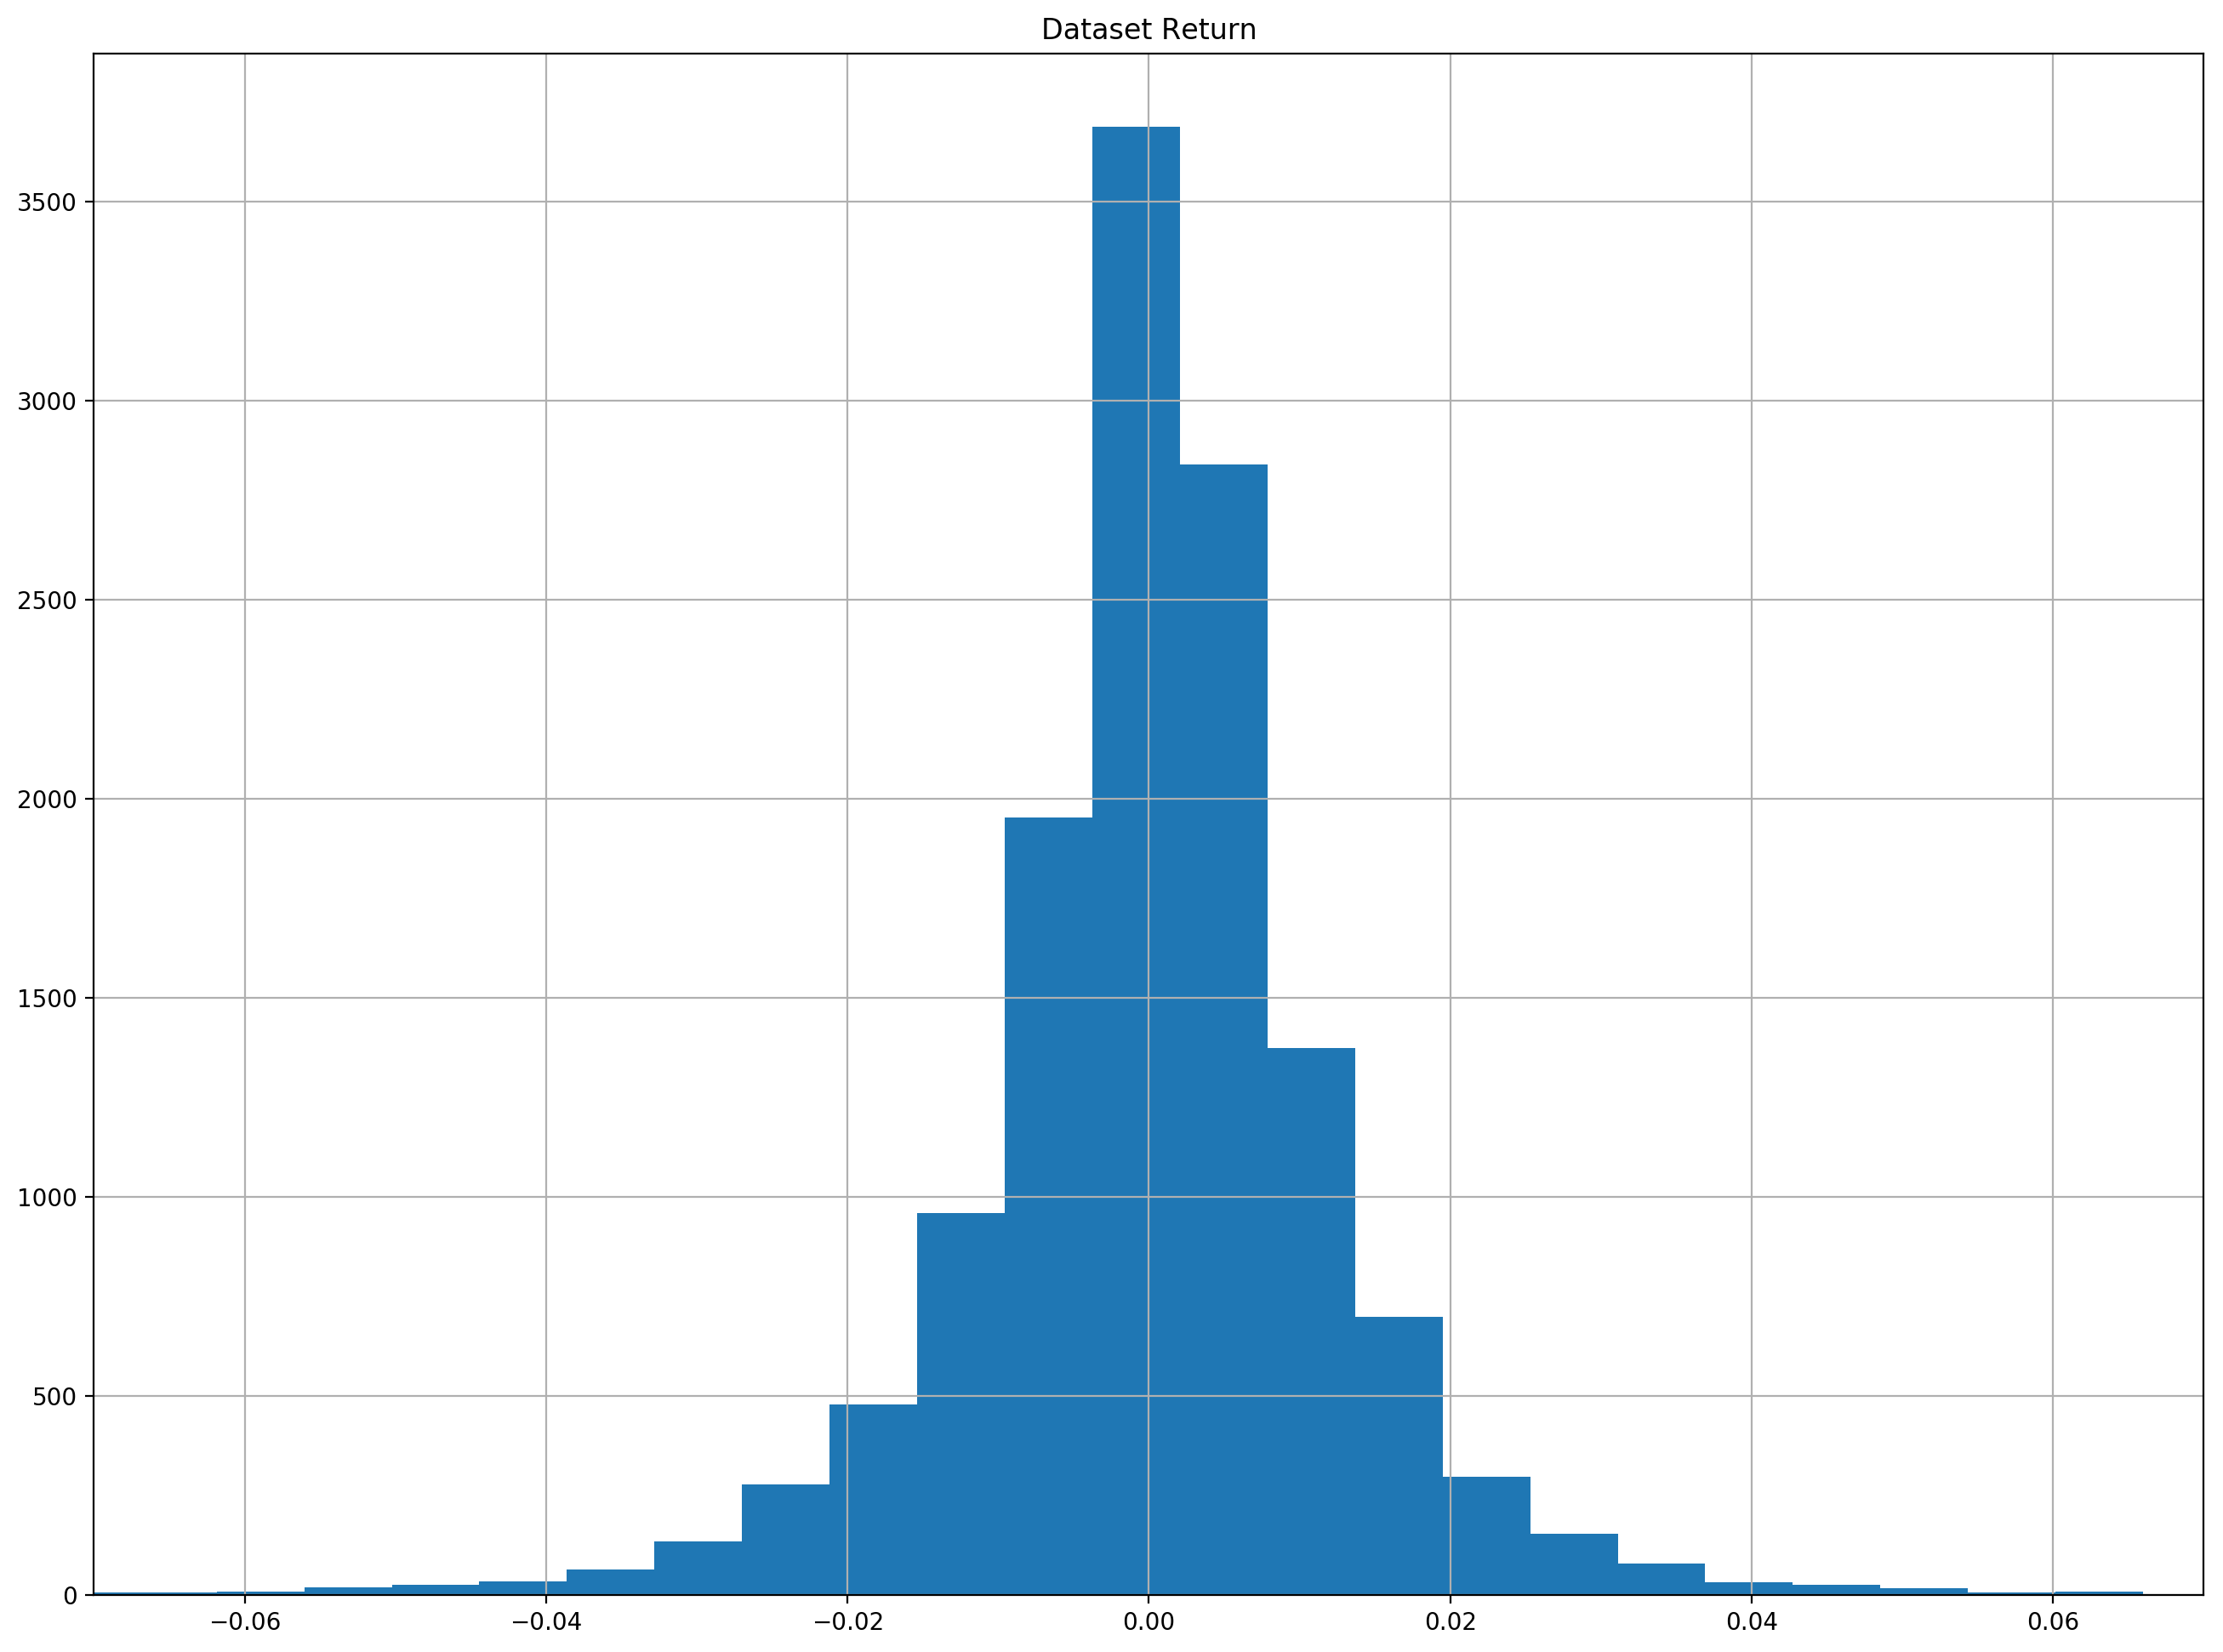

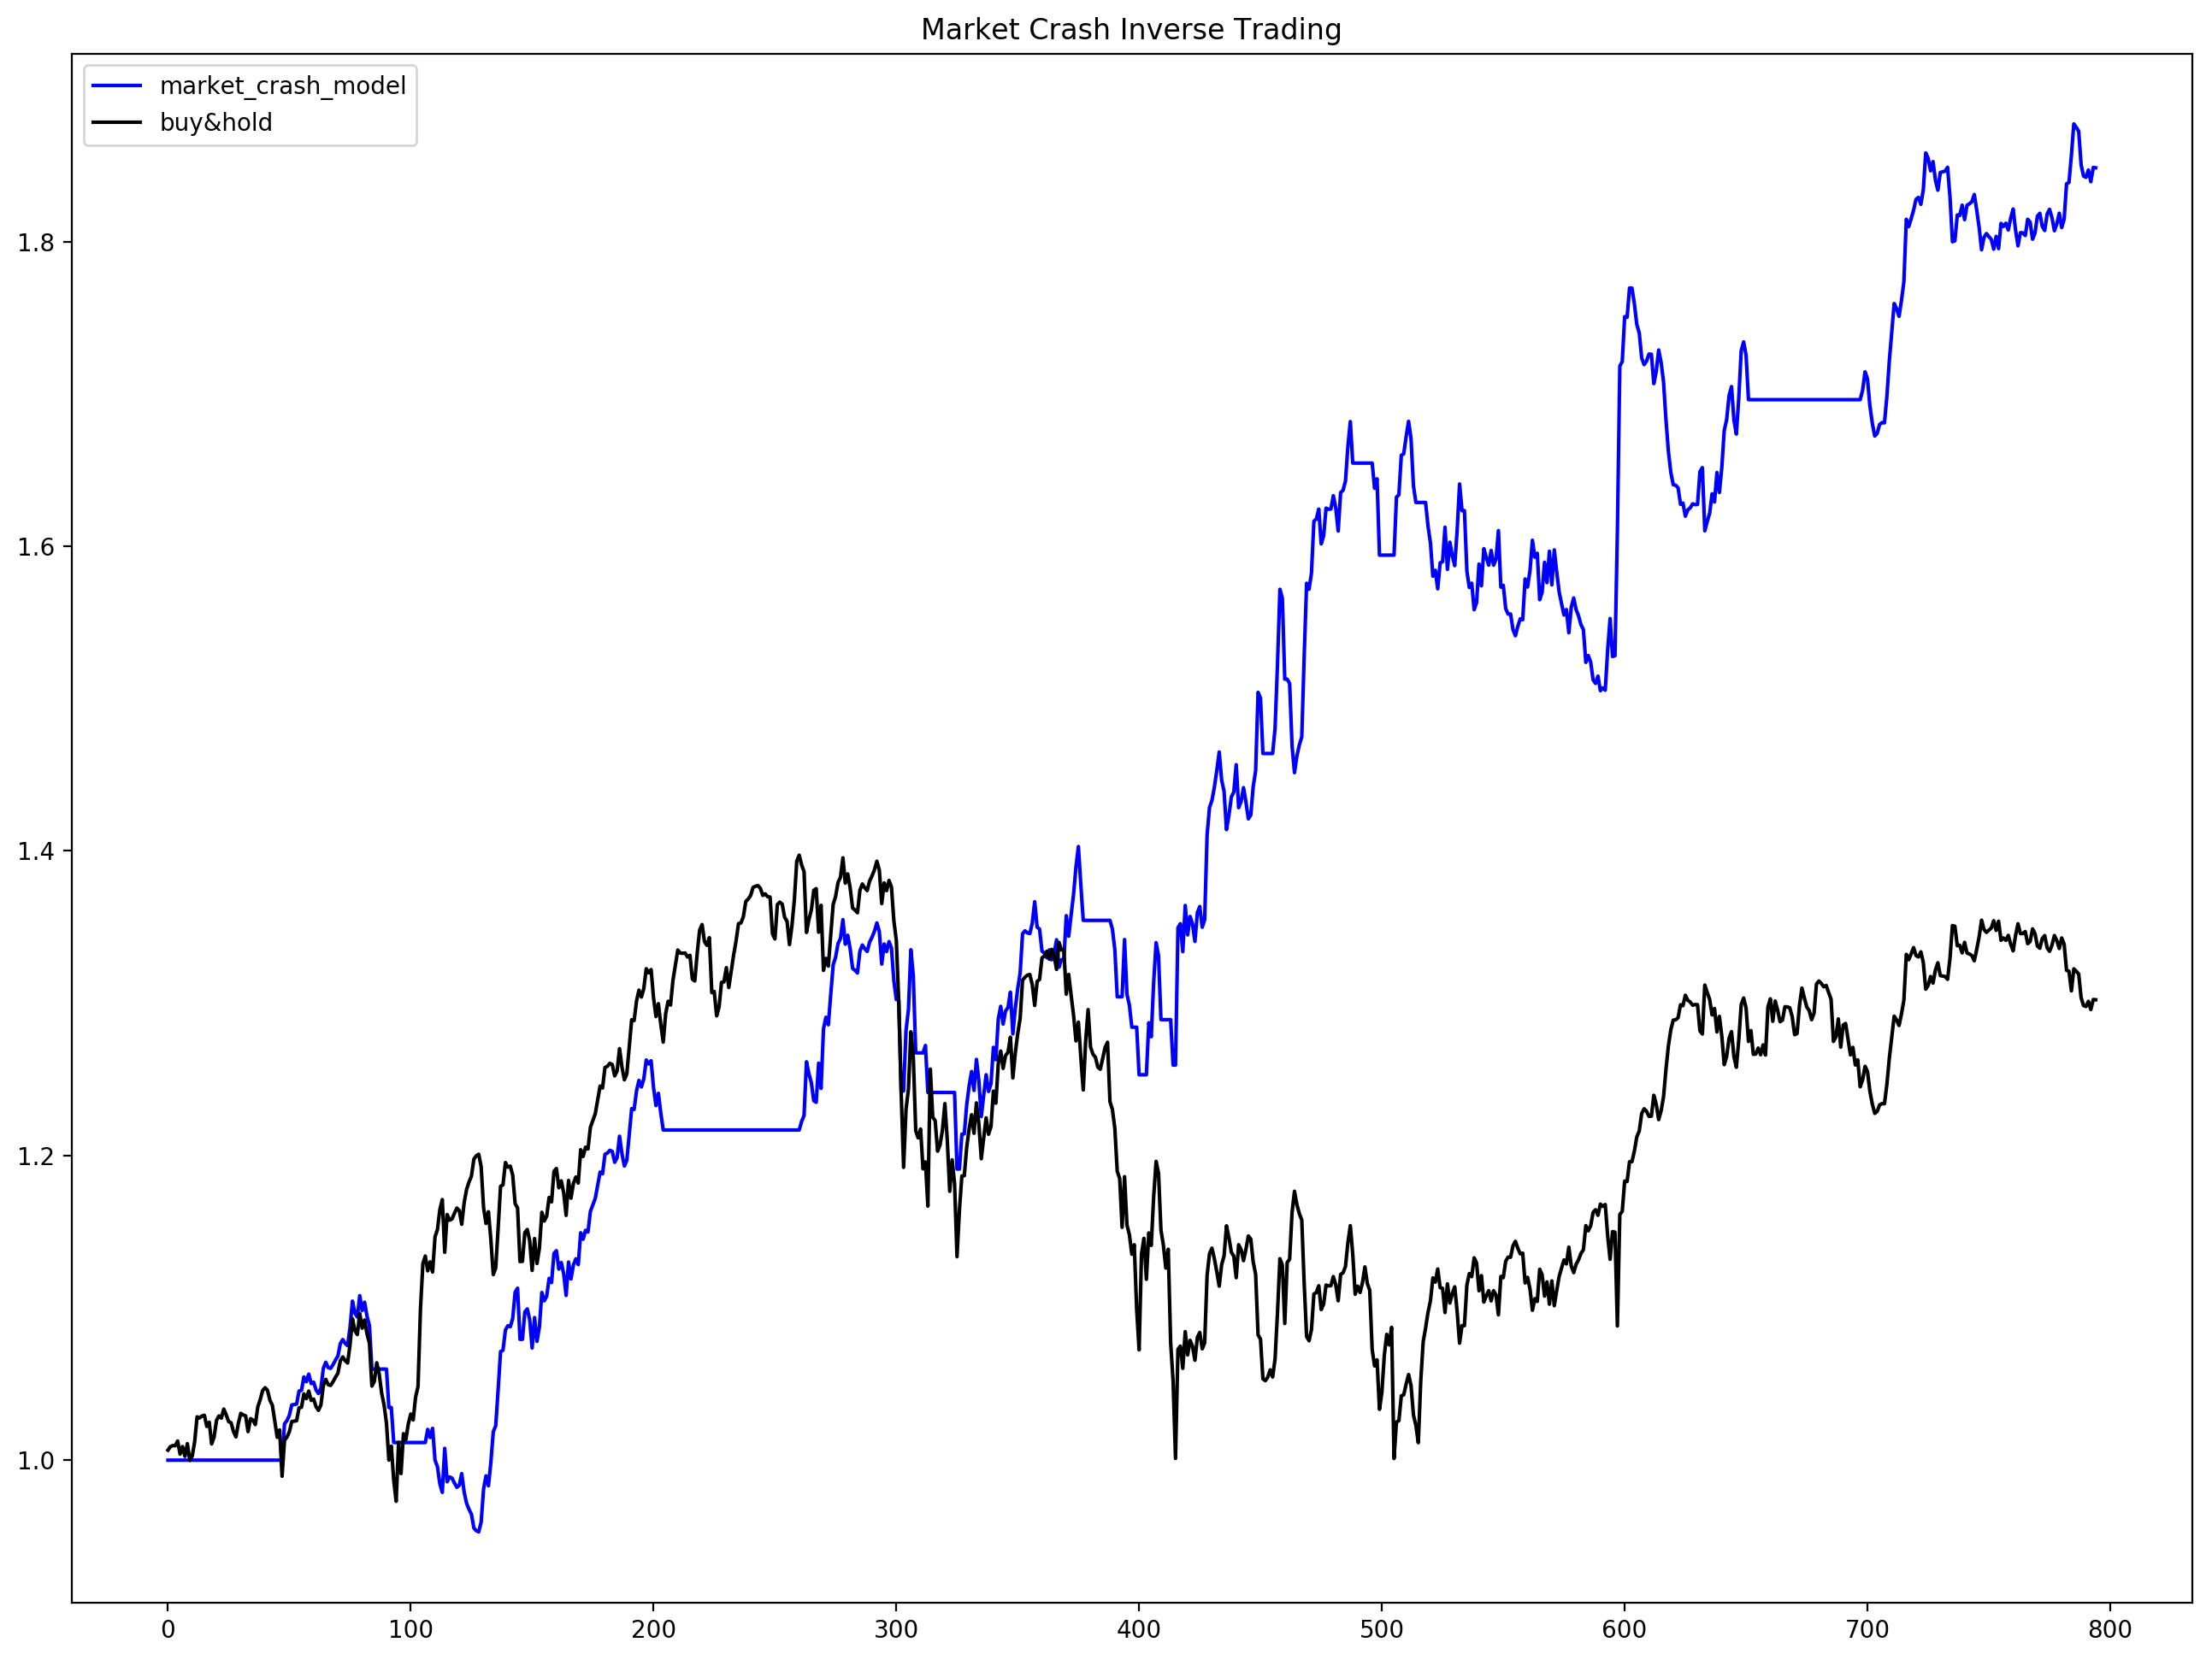

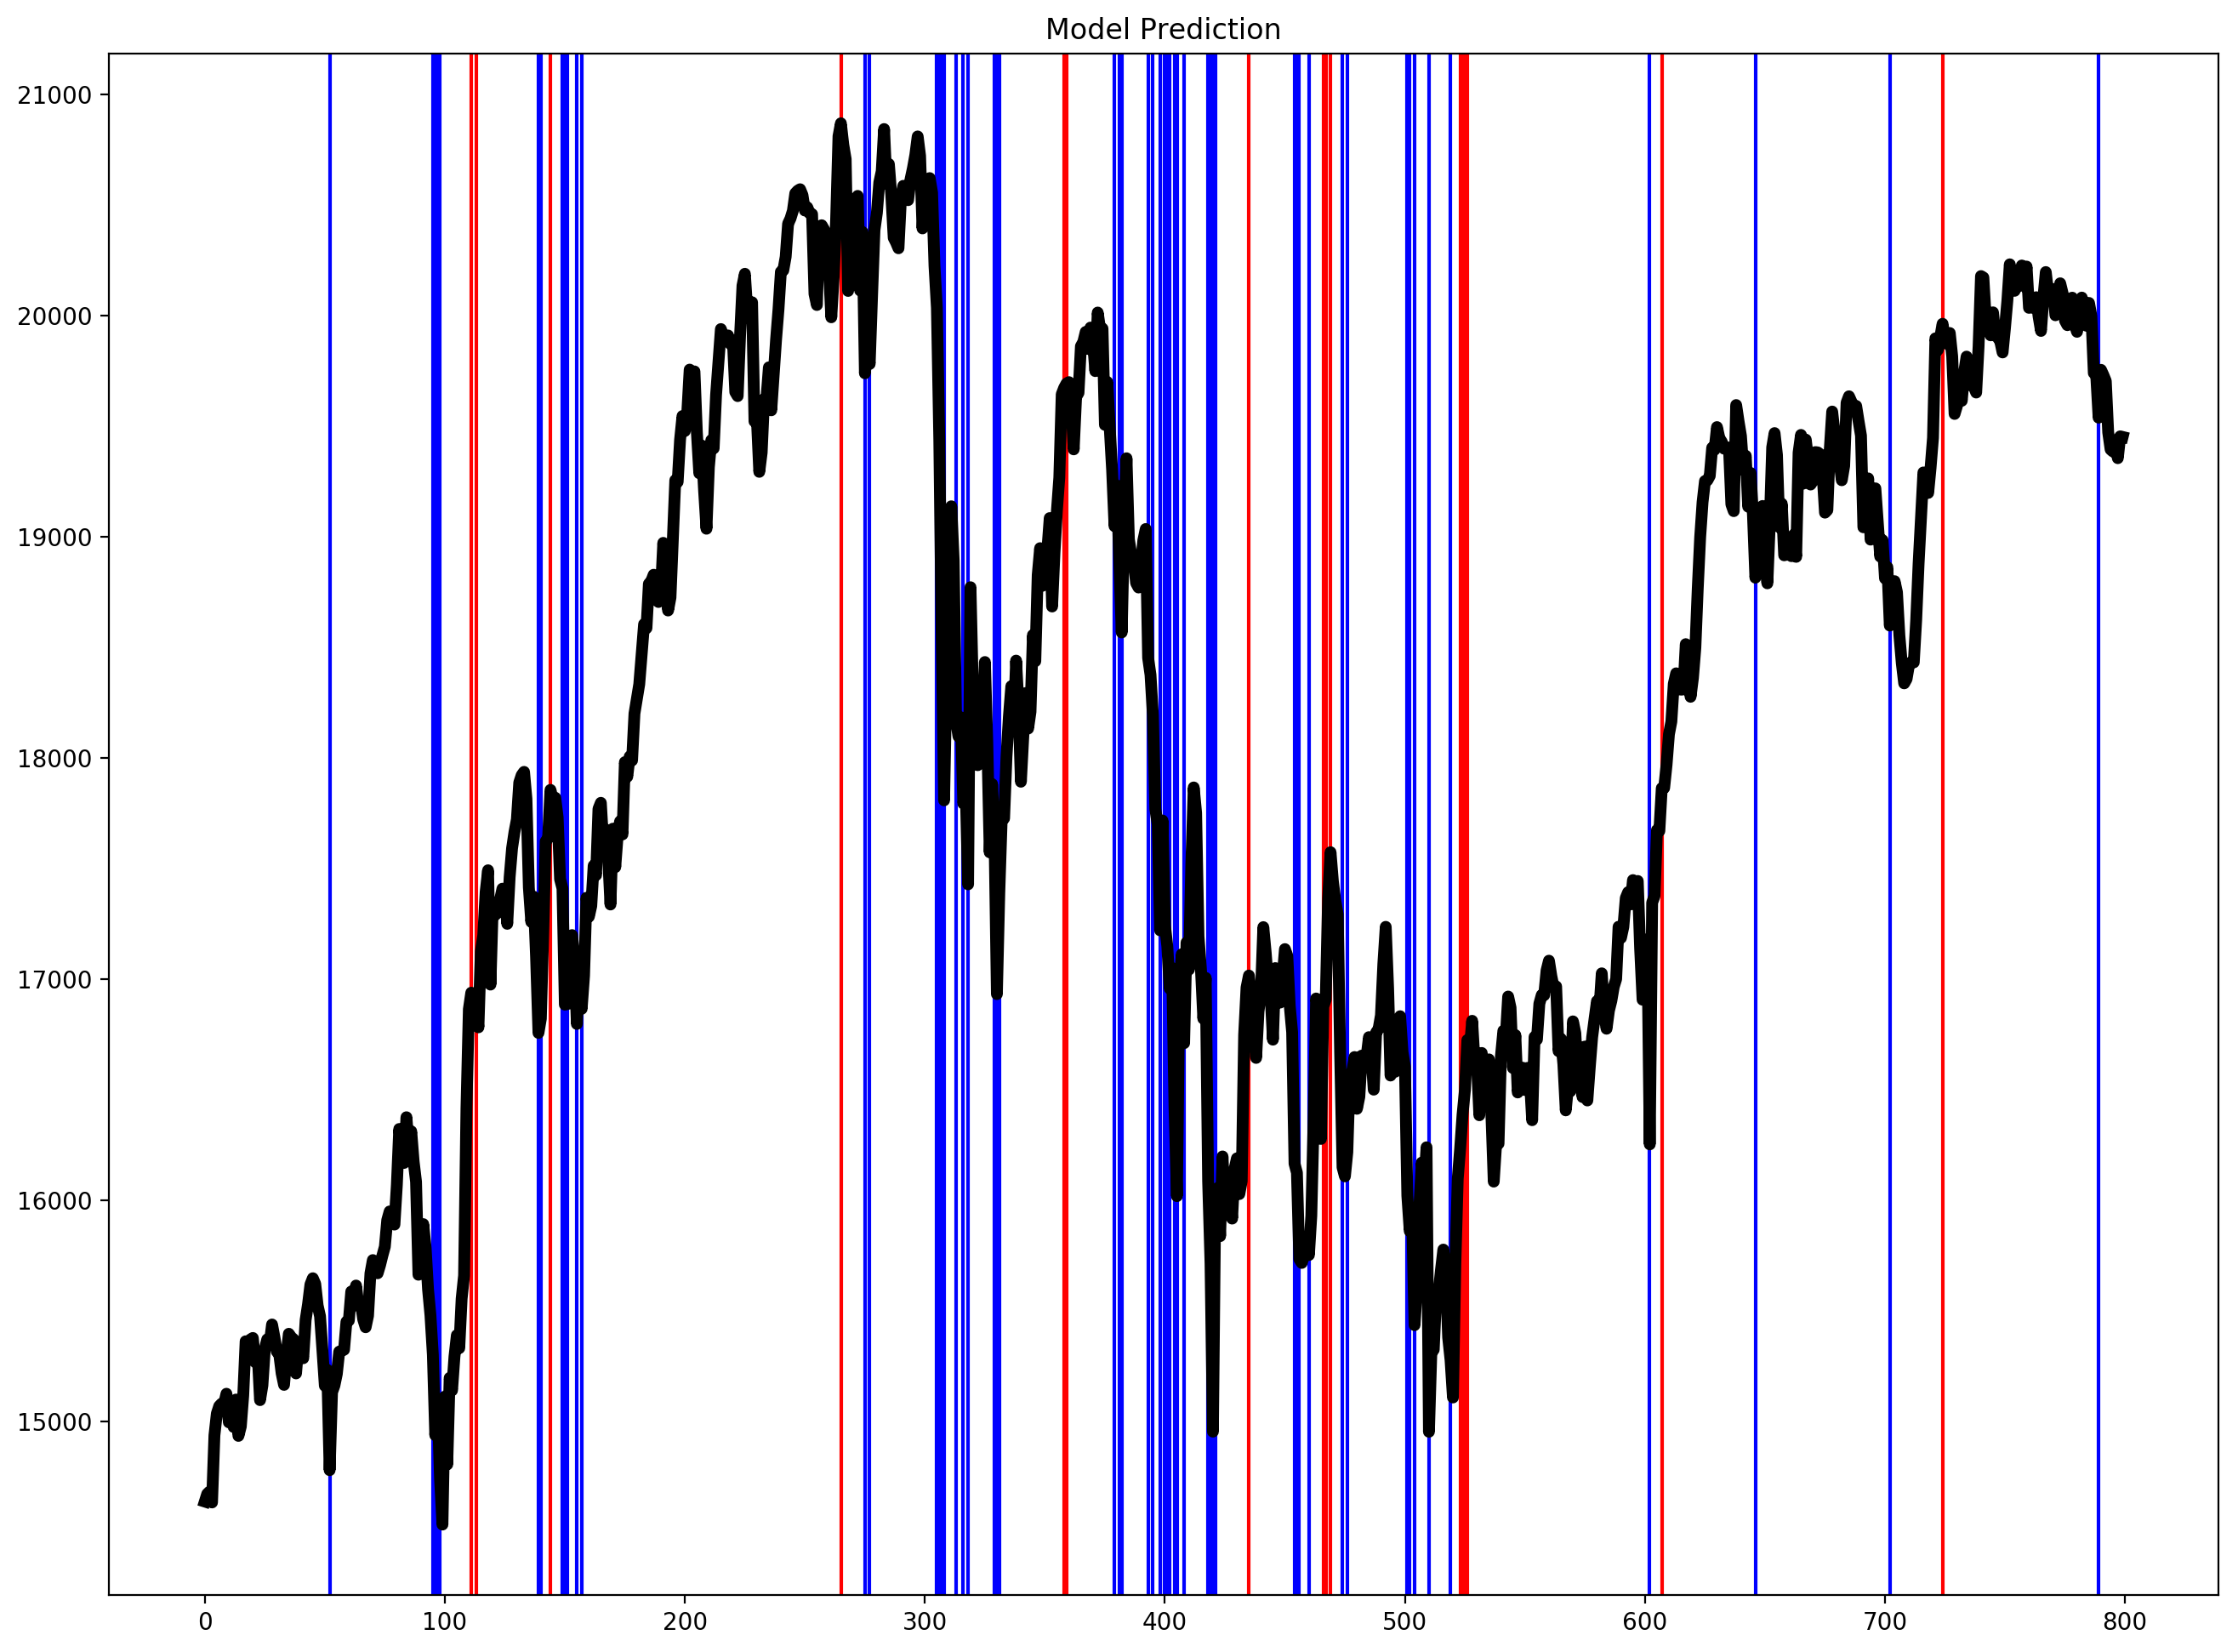

In [11]:
data = pd.read_csv("MarketData/N225_Nikkei_Daily.csv") 
data = data.dropna()

max_slope = 1 + 60
max_vol = 1 + 60
for i in range(1, max_slope):
    data['r'+str(i)] = data.Close.pct_change(i)
for i in range(5, max_vol):
    data['vol'+str(i)] = data.Close.rolling(i).std()
    
data['Return'] = data.Close.pct_change()
data = data.dropna().iloc[100:,:].reset_index().iloc[:,1:]

n= 20 # number of points to be checked before and after 
# Find local peaks
reg_target = pd.DataFrame()
reg_target['Date'] = data.Date
reg_target['Close'] = data.Close
reg_target['min'] = data.iloc[argrelextrema(data.Close.values, np.less_equal, order=n)[0]]['Close']
reg_target['max'] = data.iloc[argrelextrema(data.Close.values, np.greater_equal, order=n)[0]]['Close']

reg_target['is_min'] = (reg_target['min'] > 0).astype(int) * -1 
reg_target['is_max'] = (reg_target['max'] > 0).astype(int) * 1 
reg_target['target'] = reg_target.is_min + reg_target.is_max

reg_target = reg_target.dropna(axis=1)

train_start = 6000
train_end = train_start+6000
test_point = 800
X_train = data.iloc[train_start:train_end, 7:-1]
# X_train = data.iloc[train_start:train_end, 8:]

y_train = reg_target['target'].iloc[train_start:train_end].values
X_test = data.iloc[train_end:train_end+test_point, 7:-1]

# X_test = data.iloc[train_end:train_end+test_point, 8:]
y_test = reg_target['target'].iloc[train_end:train_end+test_point].values

price_train = data.Close.iloc[train_start:train_end].values
price_test = data.Close.iloc[train_end:train_end+test_point].values


regr2 = joblib.load('Weight/random_forest_Nikkei.pkl')

print('train score : ', regr2.score(X_train, y_train))
print('test score : ', regr2.score(X_test, y_test))

pred_train = regr2.predict(X_train)
pred_test = regr2.predict(X_test)*n
    
action = 0 
ret = 1
bh = 1 
log_ret = [] 
log_bh = [] 
action_vol = 5 
vol_buy = 80
vol_sell = 250
rule_buy = -1
rule_sell = 1 

cost = 1 
move_trailing = 1.03
stop_loss = 0.985
nikkei_count_action = 0 
for i in range(action_vol, len(price_test)):
    change = (price_test[i] - price_test[i-1])/price_test[i-1]
    vol = price_test[i-action_vol:i].std()
    ret = ret * (1+change*action)
    bh = bh * (1+change)
    if pred_test[i] >= rule_sell and vol >= vol_sell: 
        action = -1
        cost = 0 
    elif pred_test[i] <= rule_buy  and vol >= vol_buy:
        if action == 0 :
            cost = ret
            nikkei_count_action += 1 
        action = 1
        
    if action == 1 and ret >= cost * move_trailing:
        cost = ret  
    if ret <= cost * stop_loss :
        action = 0 
        cost = 0  
    log_ret.append(ret)
    log_bh.append(bh)

print('Nikkei Return vs Market')
print('model', ret, 'market', bh, 'action', nikkei_count_action)

plt.figure(figsize=(16,12), dpi=200)
plt.title('Dataset Return')
data.r1.hist(bins=50)
plt.xlim(-0.07,0.07)
plt.show()


plt.figure(figsize=(16,12), dpi=200)
plt.title('Market Crash Inverse Trading')
plt.plot(log_ret, label='market_crash_model', color='blue')
plt.plot(log_bh, label='buy&hold', color='black')
plt.legend()
plt.savefig('Image/nikkei_ret.png')
plt.show()

plt.figure(figsize=(16,12), dpi=200)
plt.title("Model Prediction")
for i in range(action_vol, len(price_test)):
    vol = price_test[i-action_vol:i].std()
    if pred_test[i] >= rule_sell and vol >= vol_sell: 
        plt.axvline(i, color='red')
    elif pred_test[i] <= rule_buy  and vol >= vol_buy:
        plt.axvline(i, color='blue') 
plt.plot(price_test, color='black', linewidth=5)
plt.savefig('Image/nikkei_action.png')
plt.show()

# estimator = regr2.estimators_[5]

# export_graphviz(estimator, out_file='Image/nikkei_tree.dot', feature_names = data.iloc[:,7:-1].columns,
#                 rounded = True, proportion = False, filled = True)
# call(['dot', '-Tpng', 'Image/nikkei_tree.dot', '-o', 'Image/nikkei_tree.png', '-Gdpi=150'])
# plt.figure(figsize = (32,18))
# plt.imshow(plt.imread('Image/nikkei_tree.png'))
# plt.axis('off');
# plt.show();

ret_nikkei = ret 
mk_nikkei = bh 

train score :  0.8457834593604828
test score :  0.050974440343554805
TWII Return vs Market
model 1.358681188642945 market 1.177648704895054 action 15


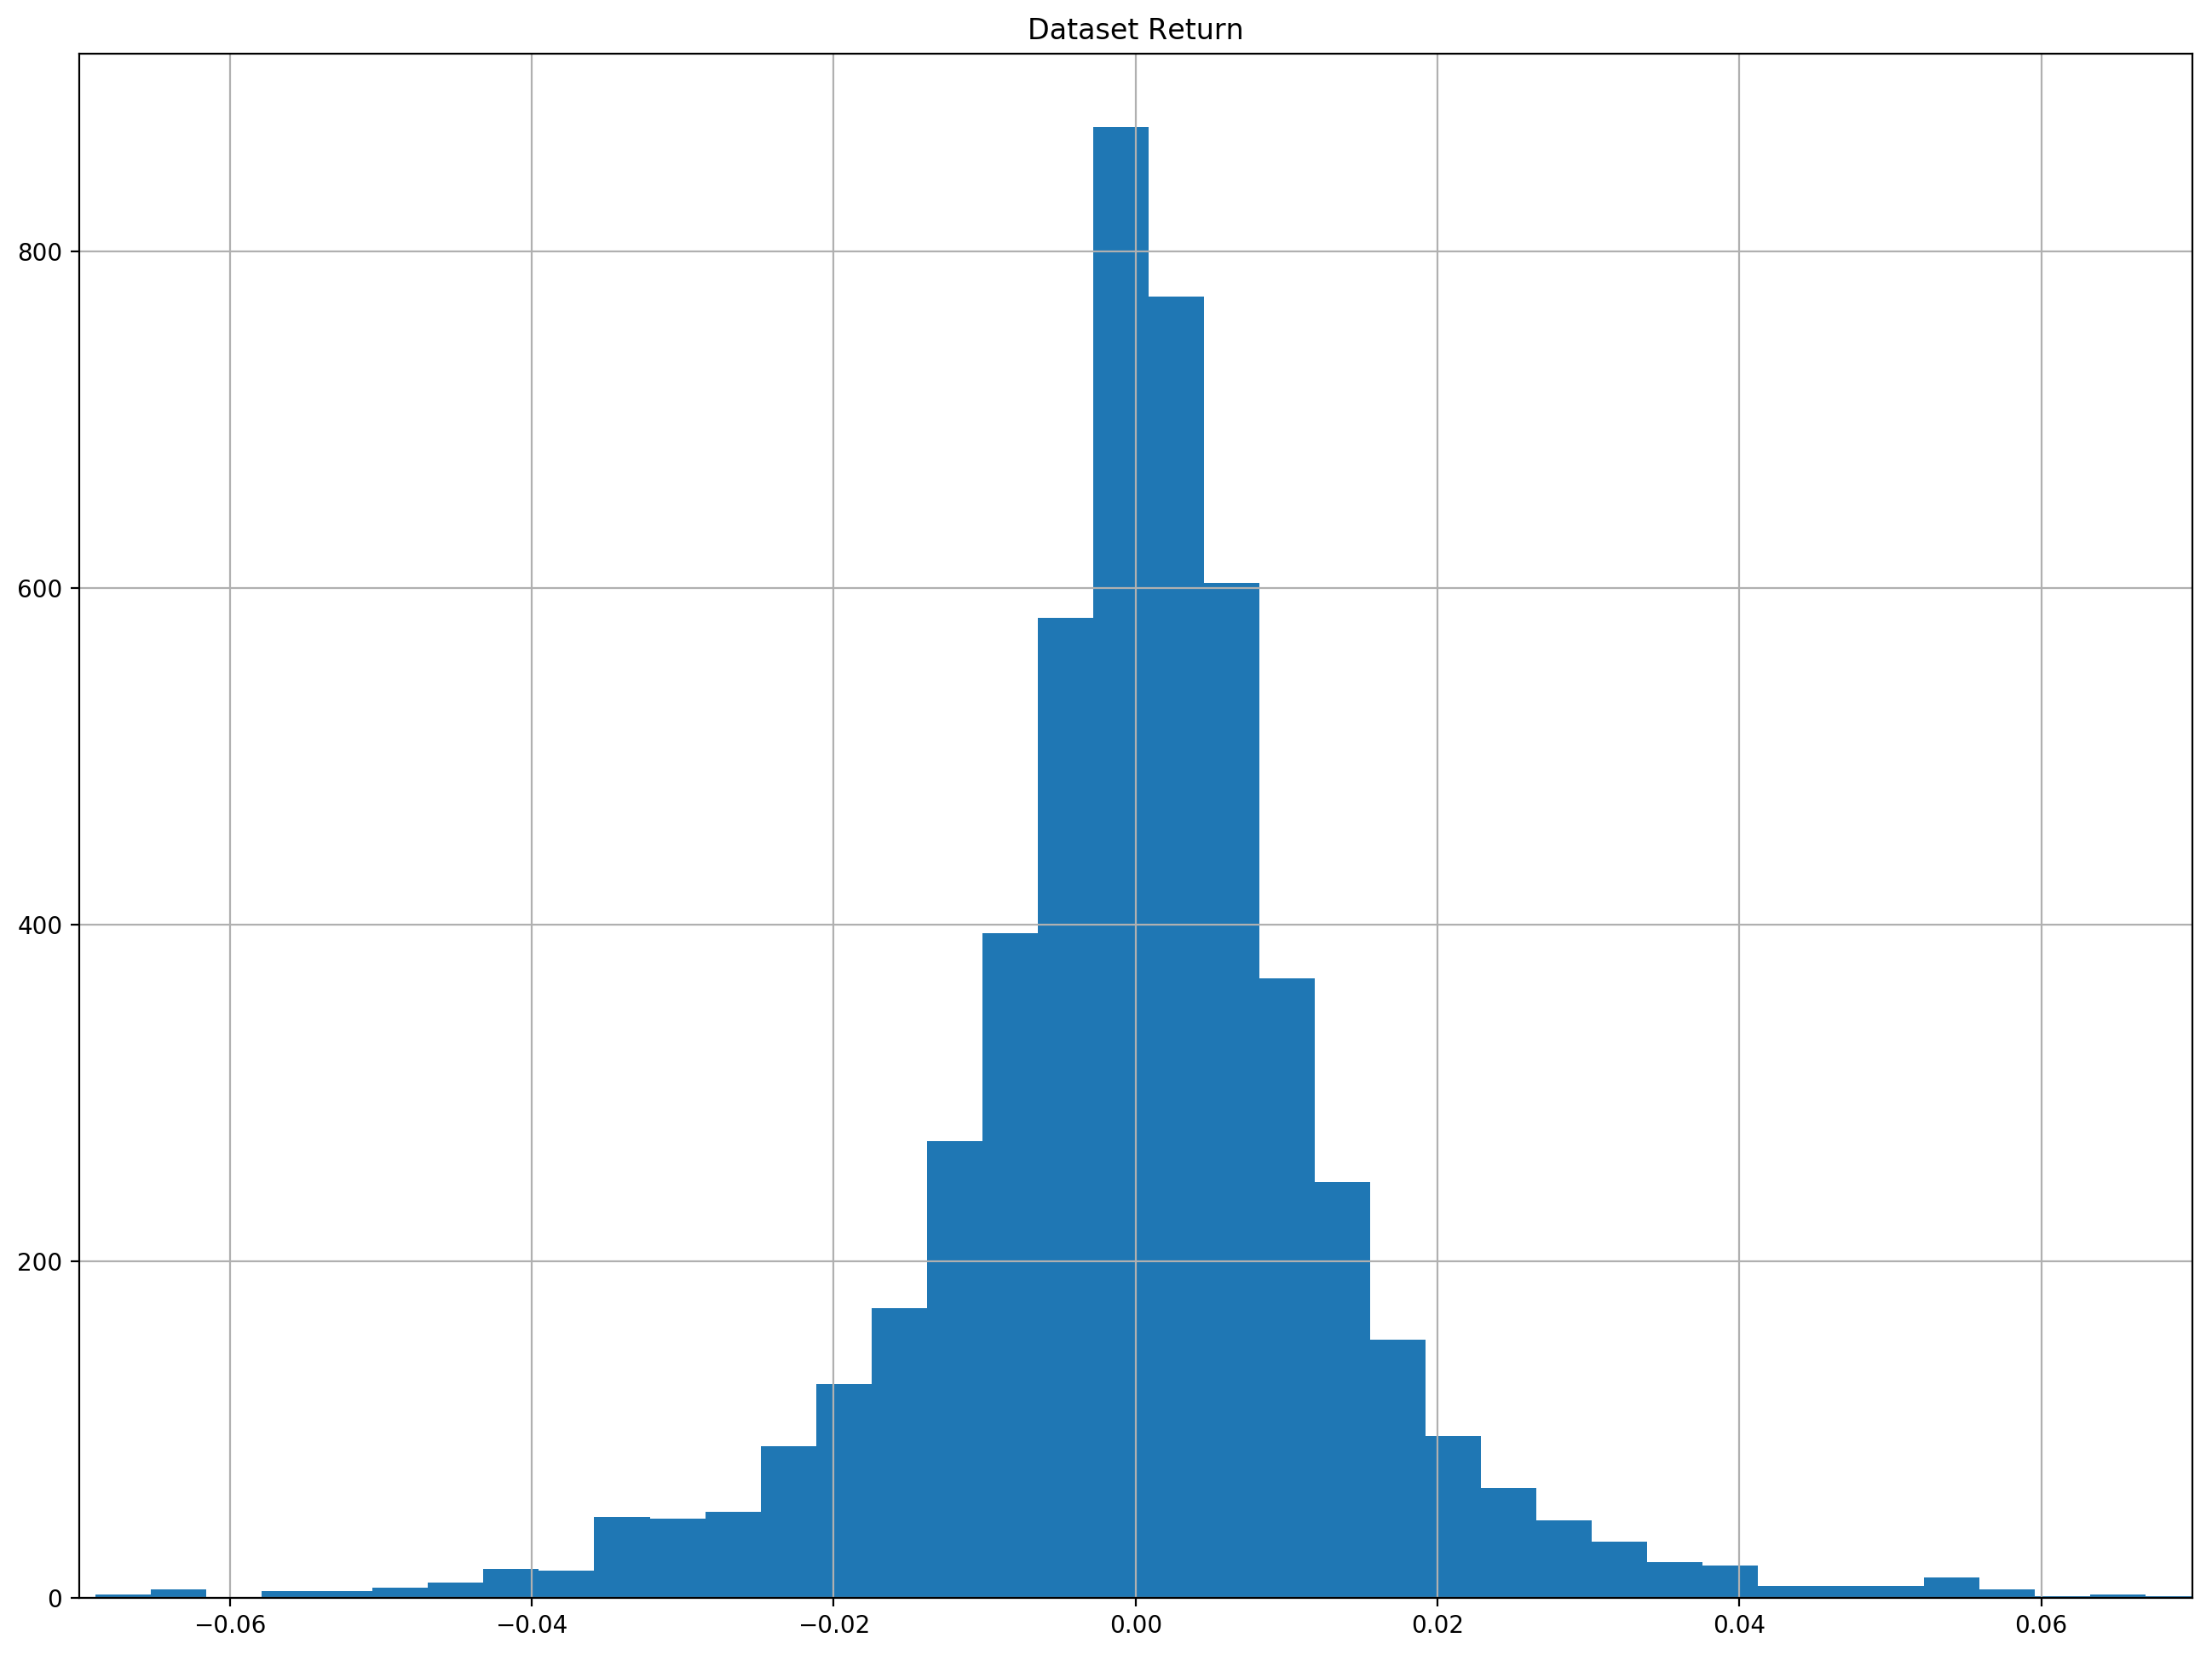

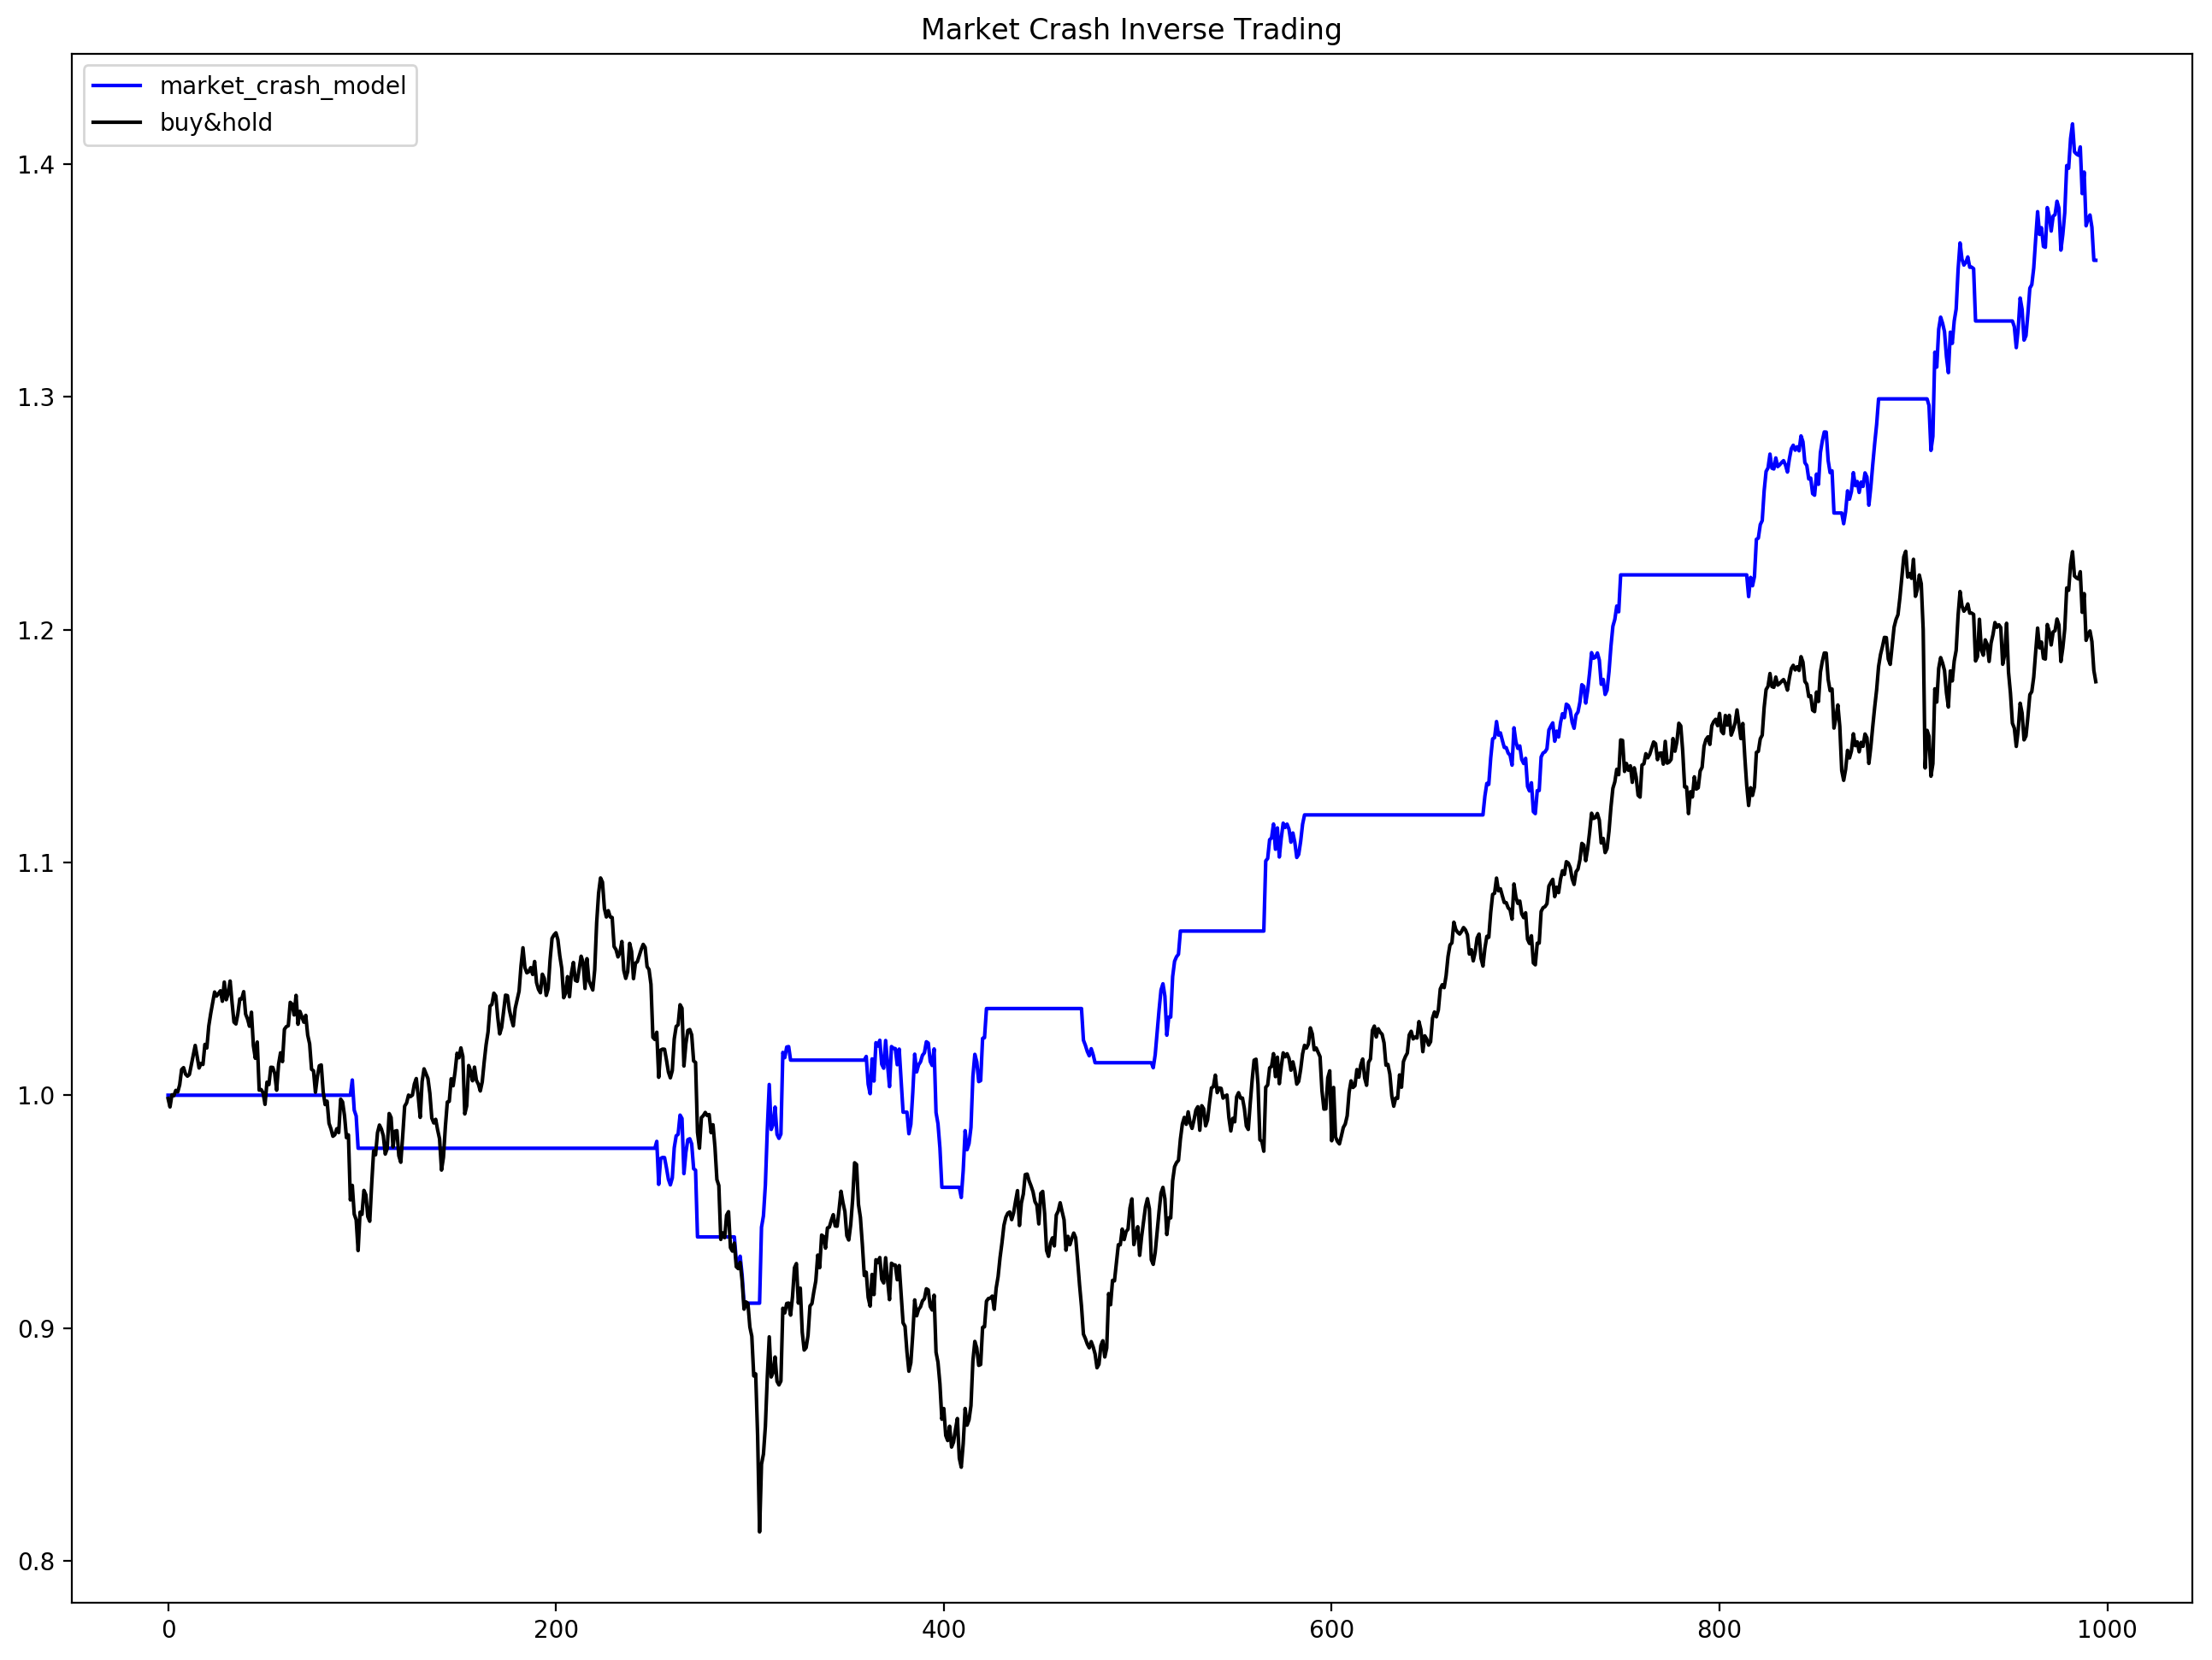

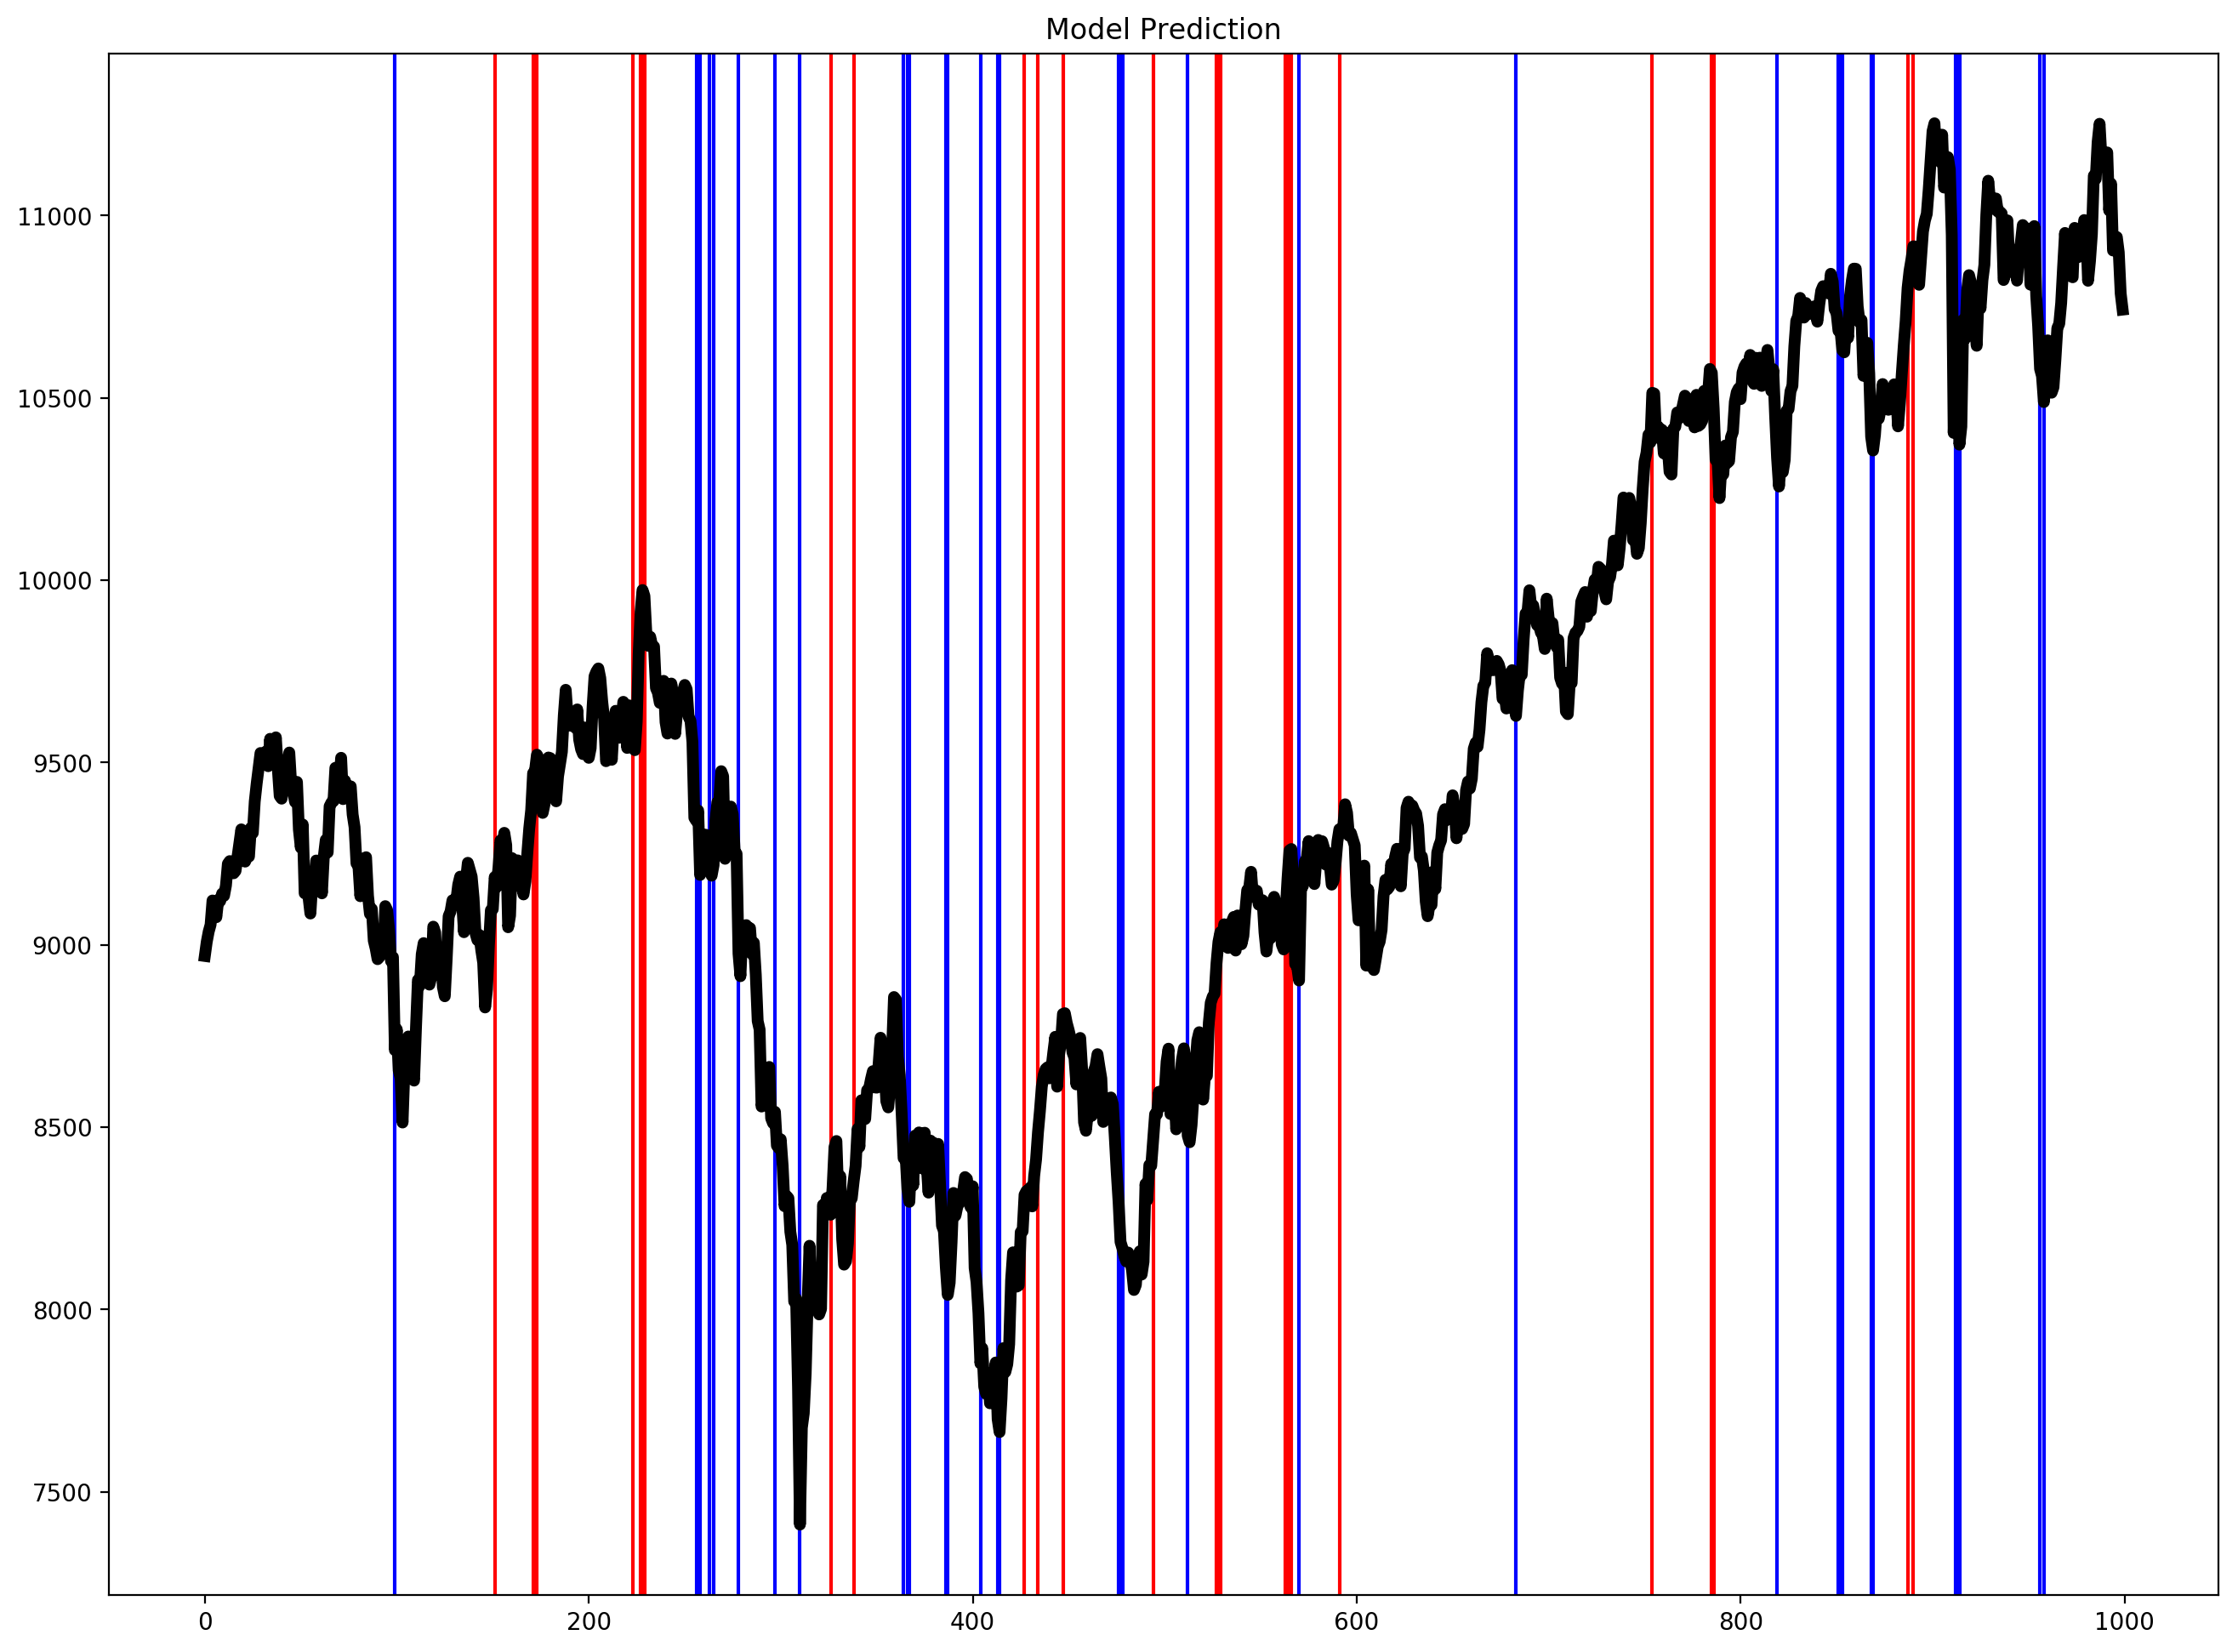

In [13]:
data = pd.read_csv("MarketData/TWII_Daily.csv") 
data = data.dropna()

max_slope = 1 + 60
max_vol = 1 + 60
for i in range(1, max_slope):
    data['r'+str(i)] = data.Close.pct_change(i)
for i in range(5, max_vol):
    data['vol'+str(i)] = data.Close.rolling(i).std()
    
data['Return'] = data.Close.pct_change()
data = data.dropna().iloc[100:,:].reset_index().iloc[:,1:]

n= 20 # number of points to be checked before and after 
# Find local peaks
reg_target = pd.DataFrame()
reg_target['Date'] = data.Date
reg_target['Close'] = data.Close
reg_target['min'] = data.iloc[argrelextrema(data.Close.values, np.less_equal, order=n)[0]]['Close']
reg_target['max'] = data.iloc[argrelextrema(data.Close.values, np.greater_equal, order=n)[0]]['Close']

reg_target['is_min'] = (reg_target['min'] > 0).astype(int) * -1 
reg_target['is_max'] = (reg_target['max'] > 0).astype(int) * 1 
reg_target['target'] = reg_target.is_min + reg_target.is_max

reg_target = reg_target.dropna(axis=1)

train_start = 0
train_end = train_start+4000
test_point = 1000
X_train = data.iloc[train_start:train_end, 7:-1]
# X_train = data.iloc[train_start:train_end, 8:]

y_train = reg_target['target'].iloc[train_start:train_end].values
X_test = data.iloc[train_end:train_end+test_point, 7:-1]

# X_test = data.iloc[train_end:train_end+test_point, 8:]
y_test = reg_target['target'].iloc[train_end:train_end+test_point].values

price_train = data.Close.iloc[train_start:train_end].values
price_test = data.Close.iloc[train_end:train_end+test_point].values


regr2 = joblib.load('Weight/random_forest_TWII.pkl')

print('train score : ', regr2.score(X_train, y_train))
print('test score : ', regr2.score(X_test, y_test))

pred_train = regr2.predict(X_train)
pred_test = regr2.predict(X_test)*n
    
action = 0 
ret = 1
bh = 1 
log_ret = [] 
log_bh = [] 
action_vol = 5 
vol_buy = 40
vol_sell = 40
rule_buy = -1
rule_sell = 1

cost = 1 
move_trailing = 1.05
stop_loss = 0.98
twii_count_action = 0 
for i in range(action_vol, len(price_test)):
    change = (price_test[i] - price_test[i-1])/price_test[i-1]
    vol = price_test[i-action_vol:i].std()
    ret = ret * (1+change*action)
    bh = bh * (1+change)
    if pred_test[i] >= rule_sell and vol >= vol_sell: 
        action = 0
        cost = 0 
    elif pred_test[i] <= rule_buy  and vol >= vol_buy:
        if action == 0 :
            cost = ret
            twii_count_action += 1  
        action = 1
        
    if action == 1 and ret >= cost * move_trailing:
        cost = ret  
    if ret <= cost * stop_loss :
        action = 0 
        cost = 0  
    log_ret.append(ret)
    log_bh.append(bh)

print('TWII Return vs Market')
print('model', ret, 'market', bh, 'action', twii_count_action)

plt.figure(figsize=(16,12), dpi=200)
plt.title('Dataset Return')
data.r1.hist(bins=50)
plt.xlim(-0.07,0.07)
plt.show()


plt.figure(figsize=(16,12), dpi=200)
plt.title('Market Crash Inverse Trading')
plt.plot(log_ret, label='market_crash_model', color='blue')
plt.plot(log_bh, label='buy&hold', color='black')
plt.legend()
plt.savefig('Image/twii_ret.png')
plt.show()

plt.figure(figsize=(16,12), dpi=200)
plt.title("Model Prediction")
for i in range(action_vol, len(price_test)):
    vol = price_test[i-action_vol:i].std()
    if pred_test[i] >= rule_sell and vol >= vol_sell: 
        plt.axvline(i, color='red')
    elif pred_test[i] <= rule_buy  and vol >= vol_buy:
        plt.axvline(i, color='blue') 
plt.plot(price_test, color='black', linewidth=5)
plt.savefig('Image/twii_action.png')
plt.show()

# estimator = regr2.estimators_[5]

# export_graphviz(estimator, out_file='Image/twii_tree.dot', feature_names = data.iloc[:,7:-1].columns,
#                 rounded = True, proportion = False, filled = True)
# call(['dot', '-Tpng', 'Image/twii_tree.dot', '-o', 'Image/twii_tree.png', '-Gdpi=150'])
# plt.figure(figsize = (32,18))
# plt.imshow(plt.imread('Image/twii_tree.png'))
# plt.axis('off');
# plt.show();

ret_TWII = ret 
mk_TWII = bh 

In [14]:
print('---- Summary ----')
print("ret FCHI", ret_FCHI, "mk FCHI", mk_FCHI, 'action', fchi_count_action*2)
print("ret nikkei", ret_nikkei, "mk nikkei", mk_nikkei, 'action', nikkei_count_action*2)
print("ret TWII", ret_TWII, "mk TWII", mk_TWII, 'action', twii_count_action*2)

---- Summary ----
ret FCHI 1.4985002224363622 mk FCHI 1.2005005471335108 action 24
ret nikkei 1.8483708455239565 mk nikkei 1.3022231300497968 action 38
ret TWII 1.358681188642945 mk TWII 1.177648704895054 action 30
